In [1]:
import csv
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

## Motivation
    Of the 7 cell types, this is most well understood from the biological perspective. As a result, here is an opportunity to use existing knowledge hone the right methods. Variables to consider:
    - TF Activity vs Expression
    - Strength of filter on expression matrix
    - Expression data: Log transform or not; Batch corrected data or not
    - Prior filtering: using DamID, honing FIMO p-values

### Convert gene symbols to Gene ids

This section is taken directly from "Create TSV from Matrix"


In [2]:
gtf = pd.read_csv('~/Dev/Drosophila_inferelator/Drosophila_melanogaster.BDGP6.91.genes.gtf', sep='\t', header = None)
gene_sym_to_id = {}
gene_id_to_sym = {}
gtf.head()

,0,1,2,3,4,5,6,7,8
0,3R,FlyBase,gene,567076,2532932,.,+,.,"gene_id ""FBgn0267431""; gene_name ""Myo81F""; gen..."
1,3R,FlyBase,gene,722370,722621,.,-,.,"gene_id ""FBgn0085804""; gene_name ""CR41571""; ge..."
2,3R,FlyBase,gene,1031171,1031354,.,+,.,"gene_id ""FBgn0039987""; gene_name ""CR12798""; ge..."
3,3R,FlyBase,gene,1366234,1366601,.,-,.,"gene_id ""FBgn0267798""; gene_name ""CR46123""; ge..."
4,3R,FlyBase,gene,1865108,1866008,.,-,.,"gene_id ""FBgn0267797""; gene_name ""CR46122""; ge..."


In [3]:
for (idx, row) in gtf.iterrows():
    st = row[8]
    splits = st.split(';')
    i = splits[0].split(" ")[1].strip('"')
    sym = splits[1].split(" ")[2].strip('"').rstrip(';').rstrip('"').replace(';', '')
    gene_sym_to_id[sym] = i
    gene_id_to_sym[i] = sym 

In [4]:
def convert_df_from_Fbgn_ids_to_symbols(df):
    subset_index = set(gene_id_to_sym.keys()).intersection(df.index)
    if len(subset_index) == 0:
        print 'Error: No overlap found. Aborting'
        return
    new_index = [gene_id_to_sym[i] for i in subset_index]
    lost_genes = df.shape[0] - len(new_index)
    print 'Converting dataframe. Losing {} genes out of an index size of {}'.format(lost_genes, df.shape[0])
    df = df.loc[subset_index, :]
    df.index = new_index
    return df

def convert_df_from_symbols_to_Fbgn_ids(df):
    subset_index = set(gene_sym_to_id.keys()).intersection(df.index)
    if len(subset_index) == 0:
        print 'Error: No overlap found. Aborting'
        return
    new_index = [gene_sym_to_id[sym] for sym in subset_index]
    lost_genes = df.shape[0] - len(new_index)
    print 'Converting dataframe. Losing {} genes out of an index size of {}'.format(lost_genes, df.shape[0])
    df = df.loc[subset_index, :]
    df.index = new_index
    return df

In [5]:
matrices_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/network_inputs_and_outputs/inputs/03_02_2018"
mat_file = 'TF_data.csv'

In [6]:
exp = pd.read_csv(os.path.join(matrices_dir, mat_file), sep=',', index_col  = 0) #sep='\t',
exp = convert_df_from_symbols_to_Fbgn_ids(exp)

Converting dataframe. Losing 76 genes out of an index size of 11264


In [7]:
def convert_col_from_Fbgn_ids_to_symbols(col):
    new_col = [gene_id_to_sym[i] if i in gene_id_to_sym.keys() else i for i in col]
    return new_col

In [8]:
exp.head()

,soma_wtF_AAACCTGTCCGCAGTG,soma_wtF_AAAGTAGCAGACGCAA,soma_wtF_AACGTTGTCTCCAACC,soma_wtF_AACTCCCAGTGCCAGA,soma_wtF_AAGACCTTCTCTGCTG,soma_wtF_AAGTCTGTCCCTGACT,soma_wtF_AATCCAGGTTATTCTC,soma_wtF_ACACCAAAGCTTCGCG,soma_wtF_ACACCAATCACCGGGT,soma_wtF_ACGCAGCGTCGACTAT,...,soma_wtJ_TGACAACGTACGACCC,soma_wtJ_TGACTTTCAGACGCTC,soma_wtJ_TGCACCTCAAGCTGGA,soma_wtJ_TGCACCTTCACAACGT,soma_wtJ_TGCCAAACATTCGACA,soma_wtJ_TGGCGCACAGCATGAG,soma_wtJ_TGGCGCACAGCCACCA,soma_wtJ_TGTCCCATCCAATGGT,soma_wtJ_TTCGGTCAGAGCTGCA,soma_wtJ_TTGTAGGGTTGGACCC
FBgn0039266,0.498776,0.452943,1.054567,0.815635,1.438181,1.183812,1.768935,0.582660,0.000000,0.694852,...,1.405993,0.655051,0.817161,1.510867,1.156705,0.776139,1.060832,0.451694,1.664950,0.516844
FBgn0039265,1.078449,1.490115,1.054567,0.815635,1.144865,1.343779,0.963760,0.333179,0.568313,0.000000,...,0.479902,1.047488,1.063363,0.000000,0.546085,1.207805,0.903831,0.451694,0.000000,0.855884
FBgn0030674,0.000000,0.452943,0.000000,0.609987,0.728035,0.448972,0.000000,0.333179,0.000000,0.000000,...,0.000000,0.000000,0.489825,0.000000,0.000000,0.330039,0.190508,0.998024,0.728202,0.855884
FBgn0033788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FBgn0033792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
convert_df_from_symbols_to_Fbgn_ids(exp)

Error: No overlap found. Aborting


In [10]:
row_medians = exp.median(axis=1)

In [11]:
row_means = exp.mean(axis=1)

//anaconda/envs/py27.13/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


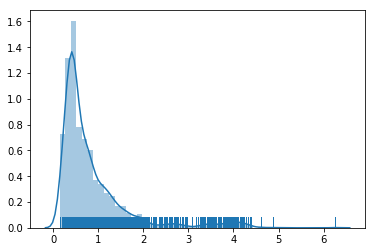

In [12]:
sns.distplot(row_medians[row_medians != 0], rug=True);

In [12]:
filtered_exp = exp[row_medians != 0]

In [13]:
filtered_exp.shape

(2317, 175)

In [14]:
# Filter for 95% non-zero

In [15]:
percent_nonzero = (exp > 0).sum(axis = 1) / exp.shape[1]
percent_nonzero_filter = .95

In [16]:
num_genes_above_filter = []
increment = .001
cutoffs = [i * increment for i in range(1005) if i * increment <= 1]
for i in cutoffs:
    num_genes_above_filter.append(percent_nonzero[percent_nonzero > i].shape[0])
    

In [17]:
cutoffs[0]

0.0

In [18]:
num_genes_above_filter_downsampled = []
increment = .1
cutoffs_downsampled = [i * increment for i in range(200) if (i * increment < 1 and  i * increment > .3)  ]
for i in cutoffs_downsampled:
    num_genes_above_filter_downsampled.append(percent_nonzero[percent_nonzero > i].shape[0])
    

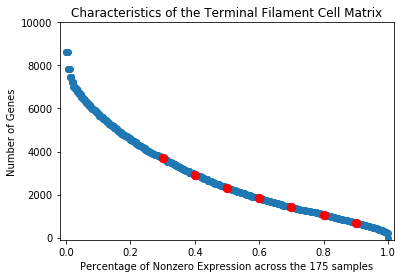

In [19]:
plt.scatter(cutoffs, num_genes_above_filter)
plt.scatter(cutoffs_downsampled, num_genes_above_filter_downsampled, c='red', s =70)
plt.xlabel('Percentage of Nonzero Expression across the {} samples'.format(exp.shape[1]))
plt.ylabel('Number of Genes')
plt.title('Characteristics of the Terminal Filament Cell Matrix')
plt.ylim( (-100, 10000) )
plt.xlim((-.02, 1.02))
plt.show()

In [137]:
# Save samples of the filter to disk for inferelator runs
for i in cutoffs_downsampled:
    temp_exp = exp[percent_nonzero > i]
    filename = 'expression_filtered_at_a_fraction_of_{}_nonzero_samples.tsv'.format(i)
    temp_exp.to_csv(os.path.join(matrices_dir, filename), sep='\t', index_col  = 0)
    print 'Rows at a fraction of {}: {}'.format(i, temp_exp.shape[0])

Rows at a fraction of 0.3: 3687
Rows at a fraction of 0.4: 2919
Rows at a fraction of 0.5: 2317
Rows at a fraction of 0.6: 1821
Rows at a fraction of 0.7: 1404
Rows at a fraction of 0.8: 1058
Rows at a fraction of 0.9: 696


In [139]:
temp_exp.head()

,soma_wtF_AAACCTGTCCGCAGTG,soma_wtF_AAAGTAGCAGACGCAA,soma_wtF_AACGTTGTCTCCAACC,soma_wtF_AACTCCCAGTGCCAGA,soma_wtF_AAGACCTTCTCTGCTG,soma_wtF_AAGTCTGTCCCTGACT,soma_wtF_AATCCAGGTTATTCTC,soma_wtF_ACACCAAAGCTTCGCG,soma_wtF_ACACCAATCACCGGGT,soma_wtF_ACGCAGCGTCGACTAT,...,soma_wtJ_TGACAACGTACGACCC,soma_wtJ_TGACTTTCAGACGCTC,soma_wtJ_TGCACCTCAAGCTGGA,soma_wtJ_TGCACCTTCACAACGT,soma_wtJ_TGCCAAACATTCGACA,soma_wtJ_TGGCGCACAGCATGAG,soma_wtJ_TGGCGCACAGCCACCA,soma_wtJ_TGTCCCATCCAATGGT,soma_wtJ_TTCGGTCAGAGCTGCA,soma_wtJ_TTGTAGGGTTGGACCC
FBgn0039266,0.498776,0.452943,1.054567,0.815635,1.438181,1.183812,1.768935,0.582660,0.000000,0.694852,...,1.405993,0.655051,0.817161,1.510867,1.156705,0.776139,1.060832,0.451694,1.664950,0.516844
FBgn0051715,0.498776,1.490115,1.452499,1.131730,0.728035,0.757718,0.732859,0.782162,0.928446,1.100884,...,1.046528,0.655051,1.425553,0.777895,1.362494,0.941603,1.370696,0.998024,0.000000,0.516844
FBgn0004907,2.843025,3.125510,2.770453,2.991180,2.702910,3.115053,3.142468,2.490817,2.692947,2.642220,...,2.634348,2.699925,3.167714,2.826601,3.060651,3.113792,2.854708,2.726171,2.837339,2.885816
FBgn0046214,1.709633,1.351877,1.336605,1.472845,2.139720,1.481651,1.857097,1.935999,1.574108,1.948830,...,1.546603,2.232931,1.690874,2.398216,1.678755,1.867842,1.928063,1.349334,1.438426,1.621438
FBgn0083167,1.078449,1.817494,1.736393,1.929032,1.438181,1.602797,0.963760,1.748290,1.401465,1.388850,...,1.046528,0.000000,1.990653,1.210086,1.362494,1.417836,1.315933,1.608798,0.728202,1.108623


In [86]:
joint_df = pd.DataFrame([percent_nonzero, row_medians]).transpose()

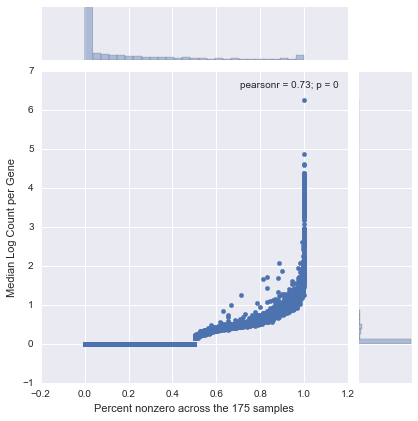

In [91]:
joint_df.columns = ['Percent nonzero across the {} samples'.format(exp.shape[1]), 'Median Log Count per Gene']
sns.jointplot(joint_df.columns[0], joint_df.columns[1], joint_df)
plt.show()

## Analysis of outputs

In [29]:
output_dir = '/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/network_inputs_and_outputs/outputs/dmel_TF_filtered_experiment'

In [30]:
first_last_folders = ['2018-03-06_14-21-10', '2018-03-06_17-42-47'] # ['2018-03-09_14-47-59', '2018-03-15_08-15-20']  # 
folders = os.listdir(output_dir)
relevant_folders = [i for i in sorted(folders) if (i >= first_last_folders[0]) & (i <= first_last_folders[1])]
relevant_folders

['2018-03-06_14-21-10',
 '2018-03-06_15-41-49',
 '2018-03-06_16-09-51',
 '2018-03-06_16-26-23',
 '2018-03-06_16-44-48',
 '2018-03-06_17-32-33',
 '2018-03-06_17-42-47']

In [31]:
# Generate networks
networks = {}
basename = 'cutoff_'
current_cutoff = .3
increment = .1
for i in relevant_folders:
    filename = os.path.join(os.path.join(output_dir, i), 'network.tsv')
    name = basename + str(current_cutoff)
    networks[name] = pd.read_csv(filename, sep='\t')
    current_cutoff += increment
    networks[name].head()
    


In [32]:
networks.keys()

['cutoff_0.6',
 'cutoff_0.7',
 'cutoff_0.4',
 'cutoff_0.5',
 'cutoff_0.3',
 'cutoff_0.8',
 'cutoff_0.9']

In [33]:
terminal_filament_specific_genes = ['glec', 'Gbp1', 'Dh44-R2', 'Mur89F', 'Dl', 'CG2852', 'ImpE1']

# Are they in the symbol list?
[t in gene_id_to_sym.values() for t in terminal_filament_specific_genes]

[True, True, True, True, True, True, True]

In [34]:
terminal_filament_specific_tfs = ['bab1','bab2', 'en']

# Are they in the symbol list?
[t in gene_id_to_sym.values() for t in terminal_filament_specific_tfs]

[True, True, True]

cutoff_0.3
    regulator target  beta.sign.sum  beta.non.zero
89        cwo     Dl           14.0           14.0
322        sc     Dl           10.0           10.0
    regulator   target  beta.sign.sum  beta.non.zero
189      bab1   CG5862           12.0           12.0
236        en      dco           11.0           11.0
271      bab1  CG17224           11.0           11.0


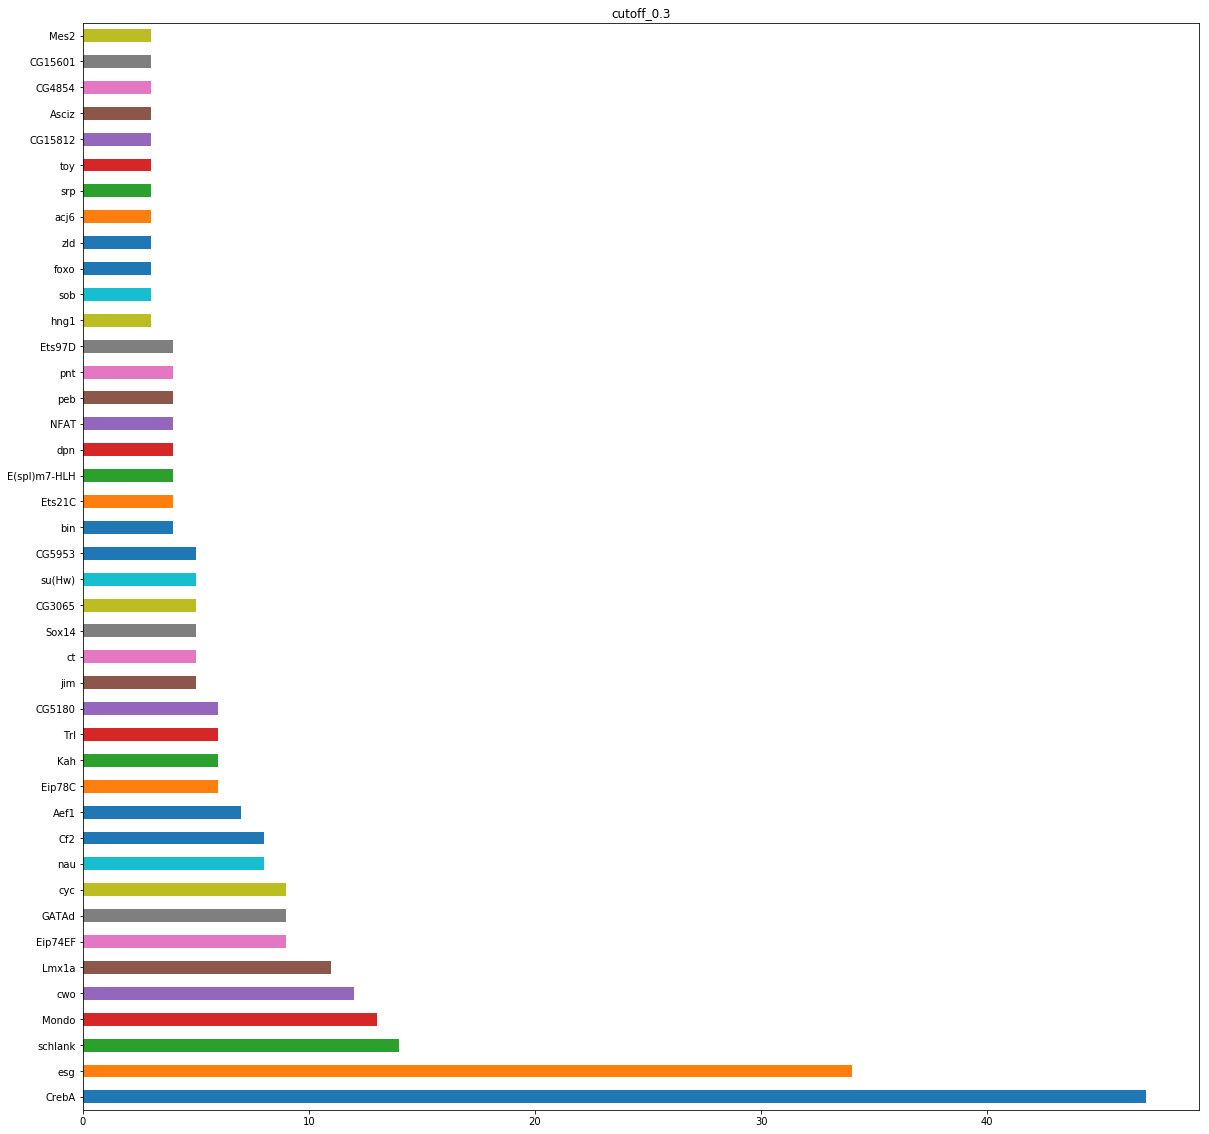

cutoff_0.4
        regulator  target  beta.sign.sum  beta.non.zero
52            cwo      Dl           16.0           16.0
199         CrebA    glec          -12.0           12.0
310  E(spl)m7-HLH  Mur89F           10.0           10.0
    regulator  target  beta.sign.sum  beta.non.zero
377      bab1  CG5862           10.0           10.0


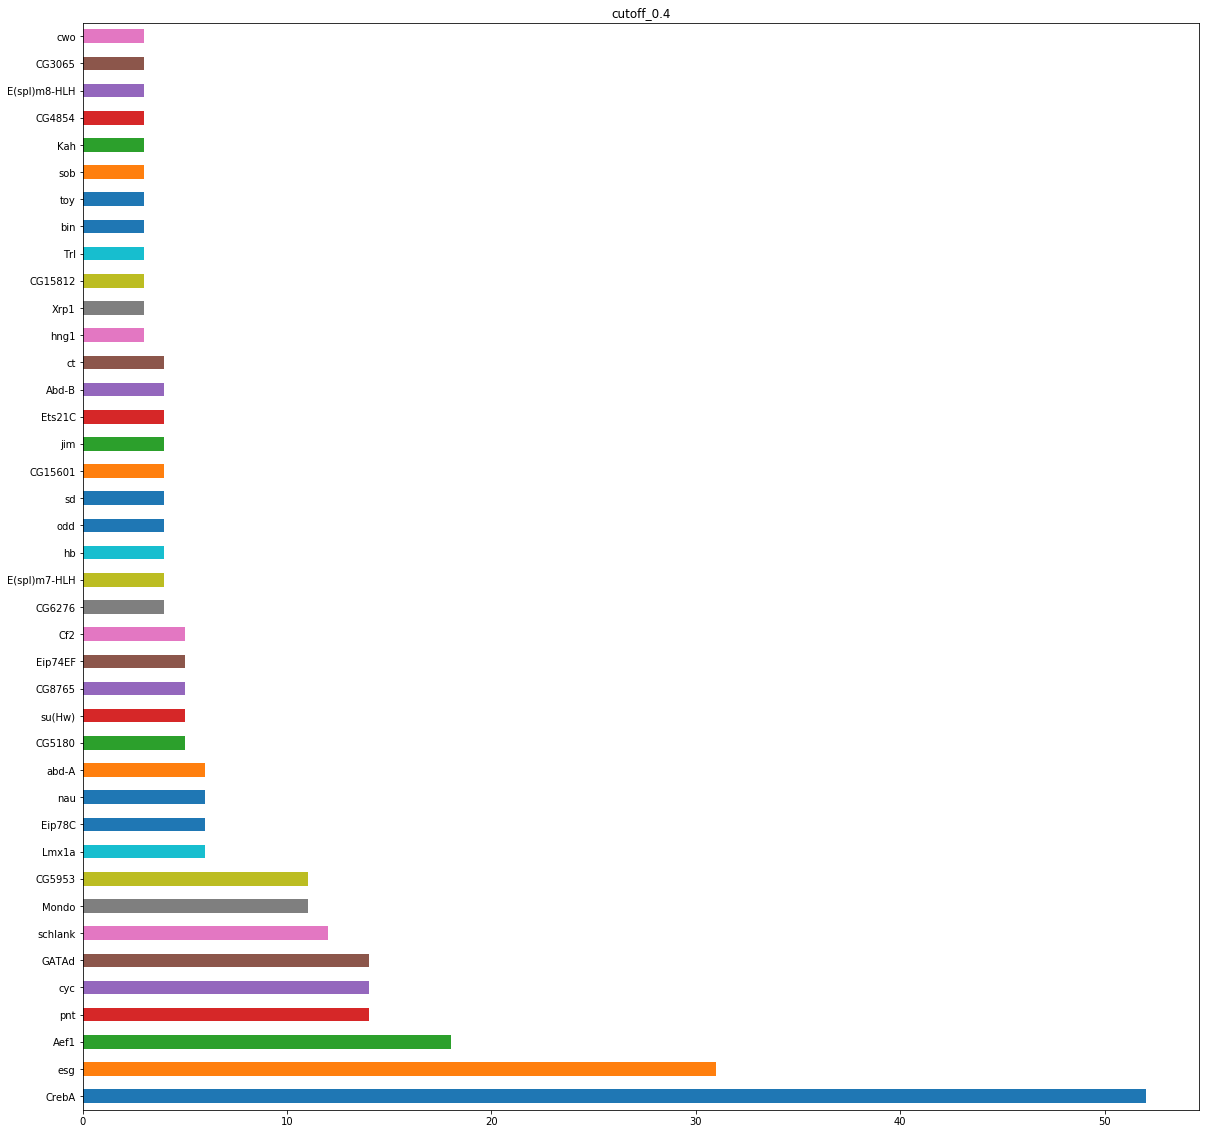

cutoff_0.5
    regulator target  beta.sign.sum  beta.non.zero
81        cwo     Dl           14.0           14.0
98        jim     Dl          -13.0           13.0
106        sc     Dl           13.0           13.0
    regulator   target  beta.sign.sum  beta.non.zero
114      bab1  CG17224           13.0           13.0
260        en      SF2           11.0           11.0
345      bab1   CG4511           10.0           10.0


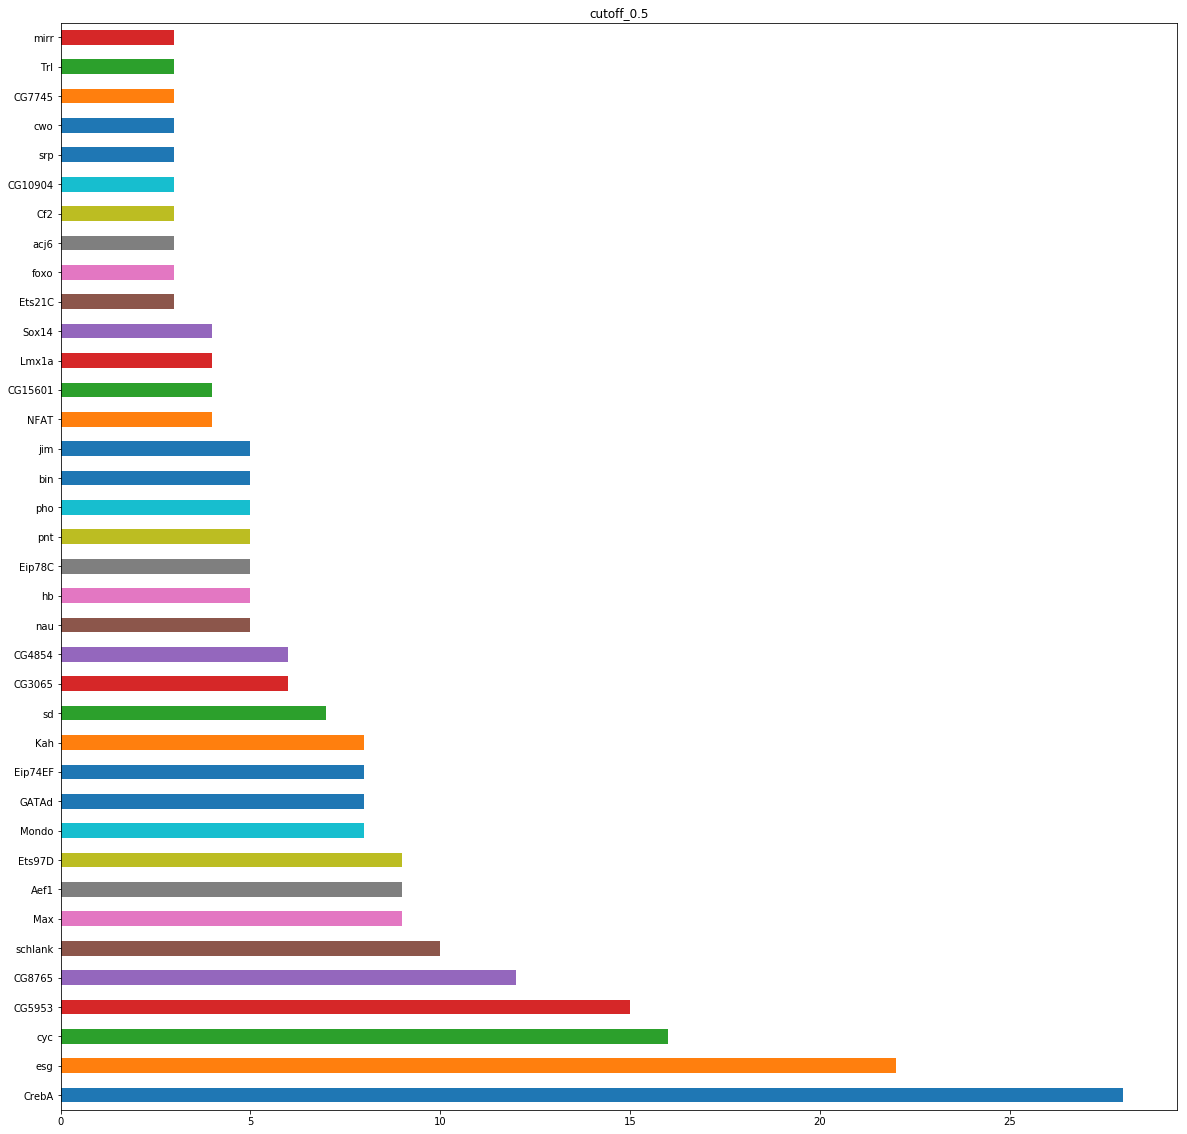

cutoff_0.6
    regulator  target  beta.sign.sum  beta.non.zero
61         sc      Dl           16.0           16.0
113     Sox14  Mur89F           14.0           14.0
246     CrebA    glec          -12.0           12.0
264       cwo      Dl           11.0           11.0
    regulator   target  beta.sign.sum  beta.non.zero
60         en      SF2           17.0           17.0
170        en    Orct2           13.0           13.0
335      bab1  Slc45-1           10.0           10.0
348      bab1  CG17224           10.0           10.0


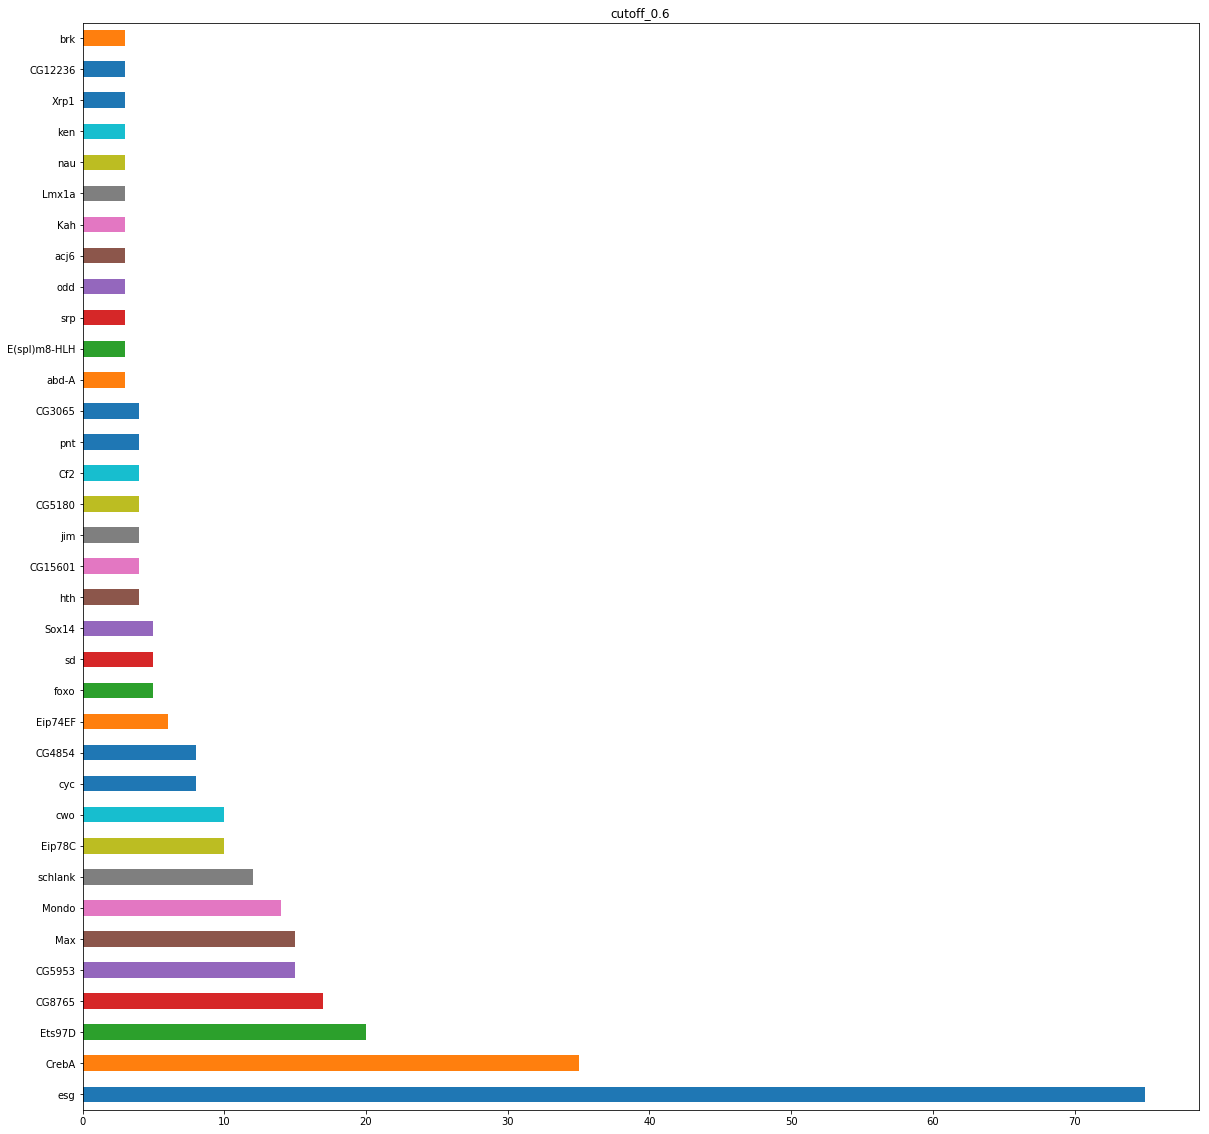

cutoff_0.7
    regulator  target  beta.sign.sum  beta.non.zero
35         sc      Dl           18.0           18.0
88      Sox14  Mur89F           15.0           15.0
163     CrebA    glec          -13.0           13.0
326     Mondo    glec           10.0           10.0
    regulator  target  beta.sign.sum  beta.non.zero
192      bab1  Tsp66E           12.0           12.0
233      bab1     ksh           11.0           11.0


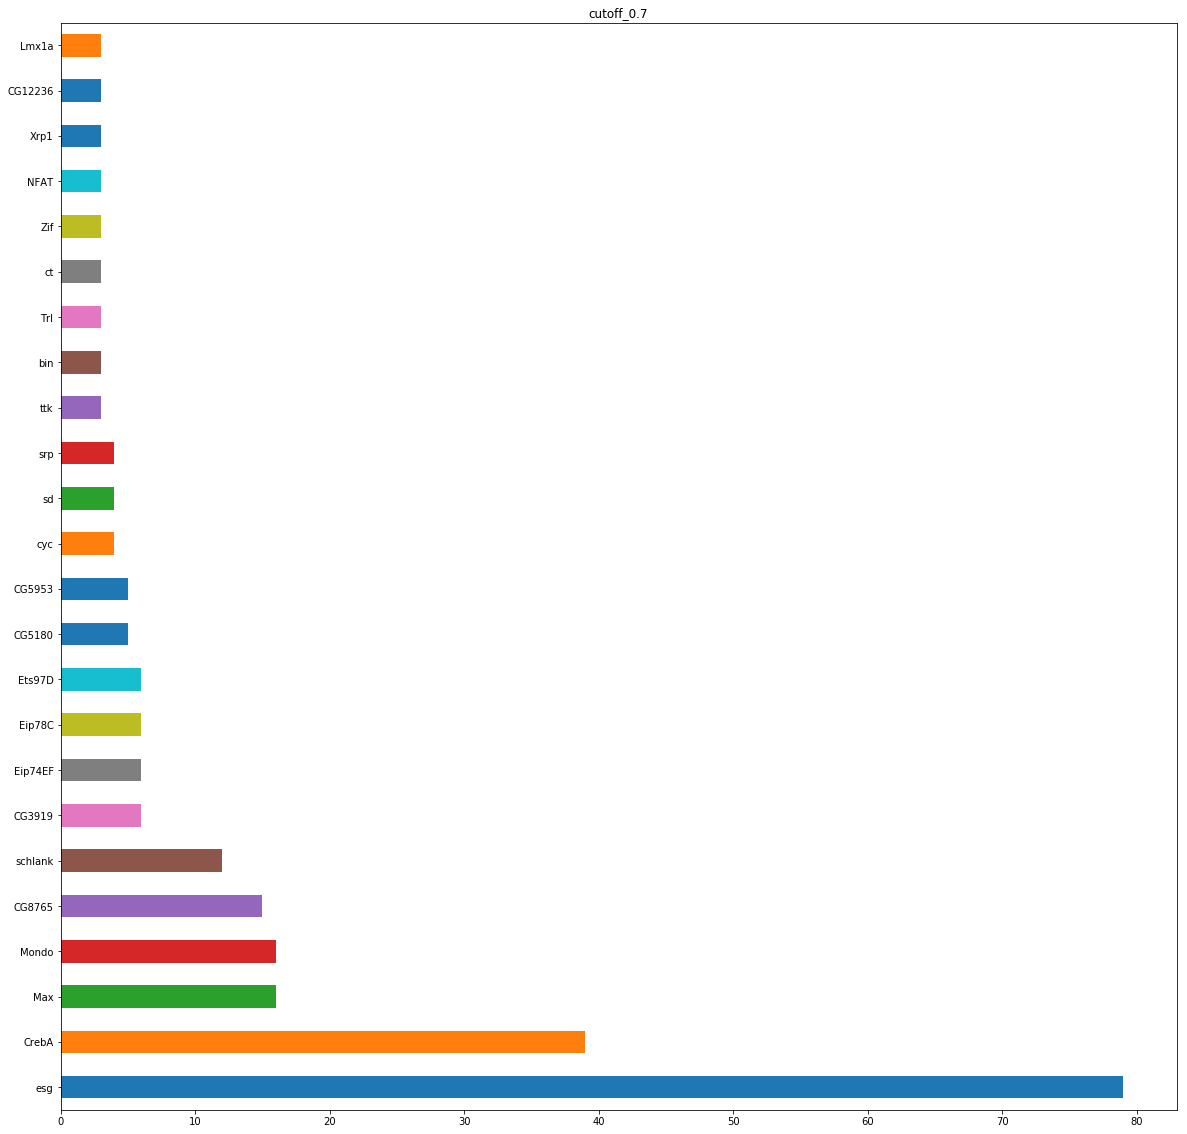

cutoff_0.8
    regulator  target  beta.sign.sum  beta.non.zero
140        sc      Dl           14.0           14.0
222    Ets97D    glec          -12.0           12.0
255       Hsf  Mur89F          -11.0           11.0
    regulator   target  beta.sign.sum  beta.non.zero
218        en      SF2           12.0           12.0
327      bab1  CG40228           10.0           10.0


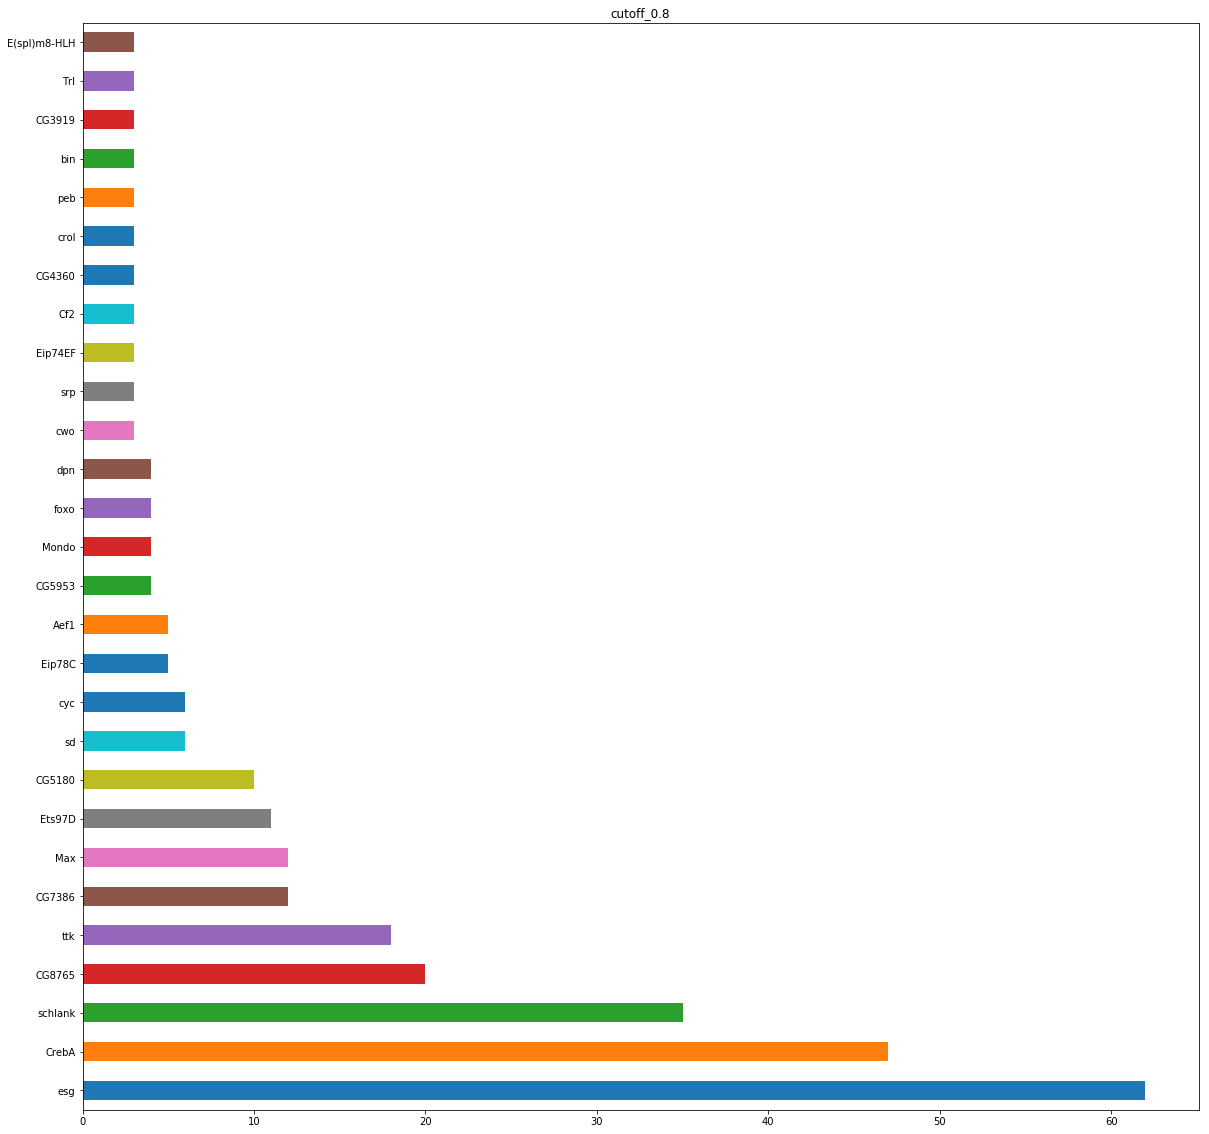

cutoff_0.9
    regulator target  beta.sign.sum  beta.non.zero
85     CG5953     Dl           15.0           15.0
216       Med     Dl          -11.0           11.0
223        sc     Dl           11.0           11.0
    regulator  target  beta.sign.sum  beta.non.zero
187      bab1  Act42A           12.0           12.0
282        en     SF2           10.0           10.0


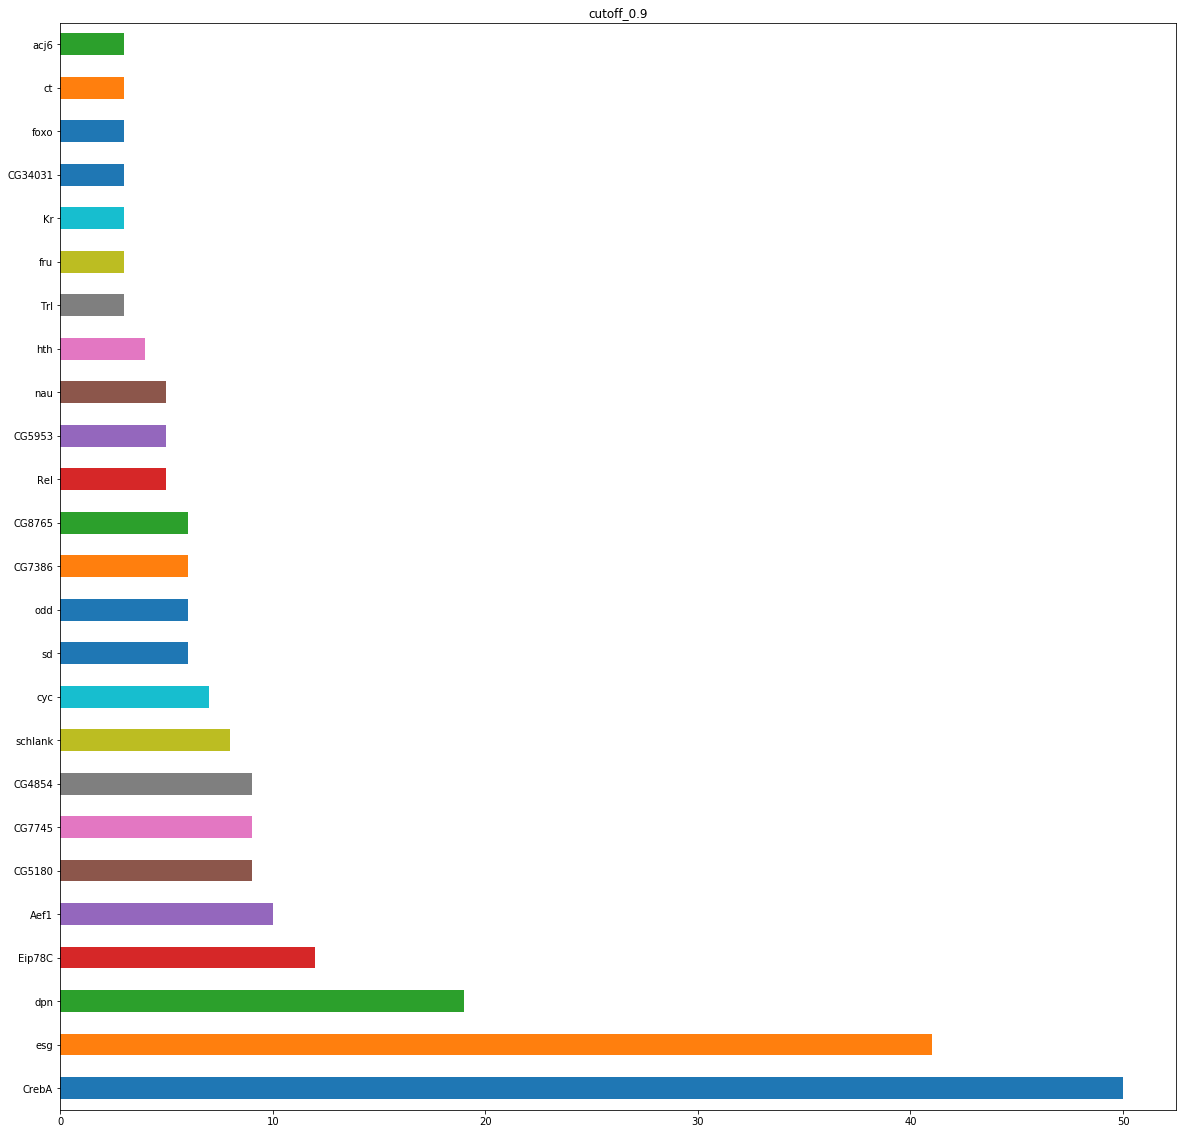

In [35]:
num_regulators = []
num_targets = []
num_edges = []
networks_symbols_high_conf = {}
for k in sorted(networks.keys()):
    plt.figure(figsize=(20,20))
    print k
    net = networks[k][networks[k]['beta.non.zero'] >= 10]
    networks_symbols_high_conf[k] = net.copy()
    networks_symbols_high_conf[k]['regulator'] = convert_col_from_Fbgn_ids_to_symbols(net['regulator'])
    networks_symbols_high_conf[k]['target'] = convert_col_from_Fbgn_ids_to_symbols(net['target'])
    regs = set(net['regulator'])
    targets = set(net['target'])    
    num_edges.append(net.shape[0])
    num_regulators.append(len(regs))
    num_targets.append(len(targets))
    some_cols = ['regulator', 'target', 'beta.sign.sum', 'beta.non.zero']
    print(networks_symbols_high_conf[k][some_cols][networks_symbols_high_conf[k]['target'].isin(terminal_filament_specific_genes)])
    print(networks_symbols_high_conf[k][some_cols][networks_symbols_high_conf[k]['regulator'].isin(terminal_filament_specific_tfs)])
    vals = networks_symbols_high_conf[k]['regulator'].value_counts()
    vals = vals[vals > 2]
    vals.plot(kind='barh')
    plt.title(k)
    plt.show()
    

In [72]:
vals = networks_symbols_high_conf['cutoff_0.6']['regulator'].value_counts()
vals = vals[vals > 2]

In [36]:
# Compute network similarity:
# Create side tables
for k in networks_symbols_high_conf:
    vals = networks_symbols_high_conf[k]['regulator'].value_counts()
    vals.to_csv('{}_counts_per_regulator.tsv'.format(k), sep='\t')
    vals = networks_symbols_high_conf[k]['target'].value_counts()
    vals.to_csv('{}_counts_per_target.tsv'.format(k), sep='\t')

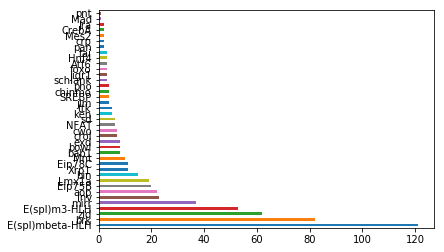

In [40]:
networks_symbols_high_conf['cutoff_0.6']['regulator'].value_counts().plot(kind='barh')

[Text(0,0,'cutoff_0.3'),
 Text(0,0,'cutoff_0.4'),
 Text(0,0,'cutoff_0.5'),
 Text(0,0,'cutoff_0.6'),
 Text(0,0,'cutoff_0.7'),
 Text(0,0,'cutoff_0.8'),
 Text(0,0,'cutoff_0.9')]

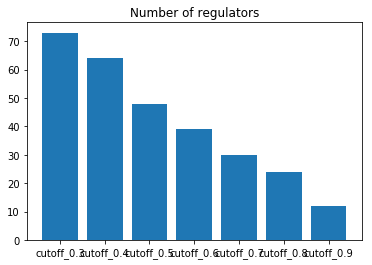

In [41]:
fig, ax = plt.subplots()
plt.title('Number of regulators')
ind = np.arange(1, 8)
ax.bar(ind, num_regulators)
ax.set_xticks(ind)
ax.set_xticklabels(sorted(networks.keys()))

In [42]:
[10 * i for i in np.arange(3,10)]

[30, 40, 50, 60, 70, 80, 90]

<BarContainer object of 7 artists>

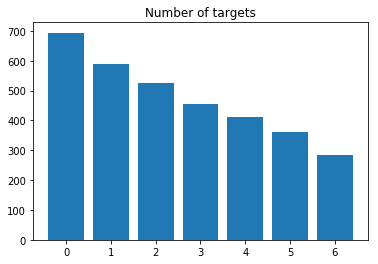

In [43]:
plt.title('Number of targets')
plt.bar(range(7), num_targets, align='center')

<BarContainer object of 7 artists>

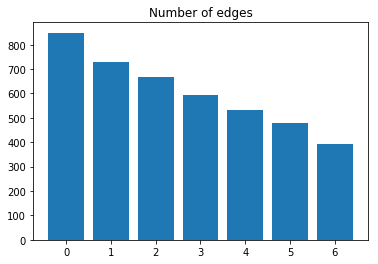

In [44]:
plt.title('Number of edges')
plt.bar(range(7), num_edges, align='center')

In [13]:
## Compare to marbach gold standard

In [9]:
fname = '~/Dev/Drosophila_inferelator/Marbach_gold_standard.tsv'
sup_table = pd.read_csv(fname, sep='\t', index_col = 0)
sup_table.head()

,FBgn0038979,FBgn0038978,FBgn0014018,FBgn0014931,FBgn0026869,FBgn0052121,FBgn0010433,FBgn0015014,FBgn0037620,FBgn0037621,...,FBgn0037876,FBgn0011655,FBgn0039227,FBgn0011656,FBgn0035238,FBgn0029928,FBgn0040366,FBgn0029920,FBgn0045852,FBgn0022935
FBgn0014931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0014930,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0035367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0027562,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0035031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
np.max(prior_gs.sum())

NameError: name 'prior_gs' is not defined

In [11]:
prior_gs.shape

NameError: name 'prior_gs' is not defined

In [7]:
fname = '~/Dev/Drosophila_inferelator/Marbach_tf_names.tsv'
sup_table.head(1).to_csv(fname, sep='\t')

In [137]:
# Compare to DAM-ID and binding site
basename = '/Users/ndeveaux/Dev/Drosophila_inferelator/priors_from_cluster'
# fname = '3_samples_merged_intersected_with_1kb_tss/priors.tsv'
# fname = '3_samples_merged_intersected_with_introns/priors.tsv'
fname = 'TSS_inferelator_input_two_percent/priors.tsv'
# fname = '3_samples_merged_intersected_with_1kb_tss_quartiles/priors.tsv'
# fname = '3_samples_merged_intersected_with_1kb_tss_decile/priors.tsv'
# fname = '3_samples_merged_intersected_with_1kb_tss_two_percent/priors.tsv'
# fname = 'TSS_inferelator_input_deciles/priors.tsv'
fname = os.path.join(basename, fname)
sup_table = pd.read_csv(fname, sep='\t', index_col = 0)


In [139]:
# replace with zero or 1
prior_gs = sup_table[sup_table == 0]
prior_gs = prior_gs.fillna(1.0)
prior_gs.head()

,FBgn0015239,FBgn0086680,FBgn0004396,FBgn0004652,FBgn0004394,FBgn0001147,FBgn0004837,FBgn0011723,FBgn0000576,FBgn0010433,...,FBgn0038418,FBgn0001150,FBgn0026411,FBgn0000659,FBgn0000233,FBgn0031573,FBgn0003145,FBgn0000014,FBgn0052830,FBgn0015561
FBgn0030647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0262993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
FBgn0014931,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0014930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0264483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [124]:
# replace with zero or 1 with a thresholding
prior_gs = sup_table[sup_table > 1]
prior_gs = prior_gs.fillna(0.0)
prior_gs = prior_gs[prior_gs == 0]
prior_gs = prior_gs.fillna(1.0)
prior_gs.head()

,FBgn0015239,FBgn0086680,FBgn0004396,FBgn0004652,FBgn0004394,FBgn0001147,FBgn0004837,FBgn0011723,FBgn0000576,FBgn0010433,...,FBgn0000462,FBgn0000459,FBgn0001983,FBgn0054031,FBgn0031573,FBgn0003145,FBgn0000014,FBgn0000659,FBgn0015561,FBgn0000546
FBgn0036752,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
FBgn0033323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0033322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0036207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0020887,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [140]:
# DENSITY?
prior_gs.sum().sum() / float(prior_gs.shape[0] * prior_gs.shape[1])

0.083902689410571427

In [50]:
prior_gs.shape

(17299, 282)

In [28]:
float(prior_gs.shape[0] * prior_gs.shape[1])

4878318.0

In [25]:
def calc_and_plot_precision_and_recall(k, net, filtered_gs):
    total_marbach_entries = filtered_gs.sum().sum()
    non_overlapping = 0
    recovered_count = 0
    precision = []
    recall = []
    count = 0
    for (idx, row) in net.iterrows():
        tf = row['regulator']
        target = row['target']
        if tf not in filtered_gs.columns or target not in filtered_gs.index:
            non_overlapping += 1
        else:
            count += 1
            if filtered_gs.loc[target, tf] == 1:
                recovered_count += 1
            precision.append(recovered_count / float(count))
            recall.append(recovered_count / total_marbach_entries)
    expected_random_precision = total_marbach_entries / float(filtered_gs.shape[0] * filtered_gs.shape[1])
    print expected_random_precision
    plt.plot(recall, precision)
    plt.ylim(ymax=.32, ymin=.001) 
    plt.axhline(y=expected_random_precision, color='r', linestyle='-')
    title = '{} : Recall and Precision against a filtered GS of size {} by {} with {} entries'.format(k, filtered_gs.shape[0], filtered_gs.shape[1], int(total_marbach_entries))
    plt.title(title)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.show()


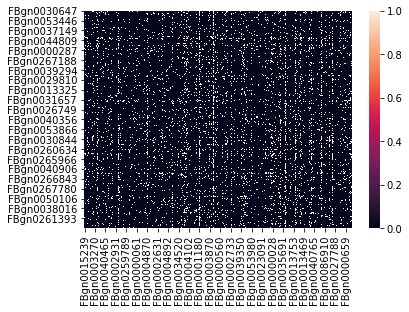

In [141]:
sns.heatmap(prior_gs)

In [33]:
set(net['target']).intersection(prior_gs.index)

{'FBgn0000042',
 'FBgn0000043',
 'FBgn0000053',
 'FBgn0000064',
 'FBgn0000097',
 'FBgn0000100',
 'FBgn0000116',
 'FBgn0000117',
 'FBgn0000150',
 'FBgn0000181',
 'FBgn0000253',
 'FBgn0000259',
 'FBgn0000426',
 'FBgn0000568',
 'FBgn0000575',
 'FBgn0000579',
 'FBgn0000658',
 'FBgn0001085',
 'FBgn0001092',
 'FBgn0001098',
 'FBgn0001105',
 'FBgn0001149',
 'FBgn0001215',
 'FBgn0001225',
 'FBgn0001248',
 'FBgn0001316',
 'FBgn0001942',
 'FBgn0002284',
 'FBgn0002526',
 'FBgn0002543',
 'FBgn0002579',
 'FBgn0002780',
 'FBgn0002921',
 'FBgn0003165',
 'FBgn0003274',
 'FBgn0003279',
 'FBgn0003360',
 'FBgn0003371',
 'FBgn0003415',
 'FBgn0003435',
 'FBgn0003502',
 'FBgn0003884',
 'FBgn0004167',
 'FBgn0004362',
 'FBgn0004363',
 'FBgn0004370',
 'FBgn0004403',
 'FBgn0004404',
 'FBgn0004432',
 'FBgn0004587',
 'FBgn0004644',
 'FBgn0004646',
 'FBgn0004656',
 'FBgn0004687',
 'FBgn0004838',
 'FBgn0004870',
 'FBgn0004876',
 'FBgn0004907',
 'FBgn0004926',
 'FBgn0005533',
 'FBgn0005585',
 'FBgn0005640',
 'FBgn00

In [27]:
for k in sorted(networks.keys()):
    net = networks[k]
    filtered_gs = prior_gs.loc[set(net['target']).intersection(prior_gs.index), set(net['regulator']).intersection(prior_gs.columns)]
    # Percentage of our network that overlaps with Marbach
    calc_and_plot_precision_and_recall(k, net, filtered_gs)

NameError: name 'prior_gs' is not defined

In [81]:
nets.keys()

NameError: name 'nets' is not defined

In [32]:
net

,regulator,target,beta.sign.sum,beta.non.zero,var.exp.median,combined_confidences,prior
27,FBgn0038852,FBgn0032774,60.0,60.0,0.720790,0.999563,0.0
30,FBgn0002735,FBgn0086711,60.0,60.0,0.600204,0.999254,0.0
63,FBgn0259234,FBgn0033351,-59.0,59.0,0.403595,0.981661,0.0
58,FBgn0003300,FBgn0025809,59.0,59.0,0.601988,0.982325,0.0
59,FBgn0038852,FBgn0038492,59.0,59.0,0.507262,0.982164,0.0
64,FBgn0016076,FBgn0011591,-59.0,59.0,0.394478,0.981643,0.0
46,FBgn0000964,FBgn0030306,-59.0,59.0,0.872560,0.983190,0.0
77,FBgn0003866,FBgn0000567,58.0,58.0,0.469943,0.965156,0.0
83,FBgn0003300,FBgn0031713,58.0,58.0,0.296945,0.963830,0.0
97,FBgn0034534,FBgn0028648,57.0,57.0,0.497364,0.948563,0.0


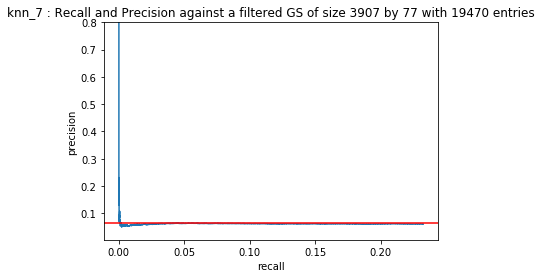

In [200]:
net = inters[0:100000]
filtered_gs = sup_table.loc[set(net['target']).intersection(sup_table.index), set(net['regulator']).intersection(sup_table.columns)]
# Percentage of our network that overlaps with Marbach
calc_and_plot_precision_and_recall(k, net, filtered_gs)

In [192]:
net.shape

(100, 7)

In [59]:
top_interactions.index

MultiIndex(levels=[[u'FBgn0000014', u'FBgn0000097', u'FBgn0000370', u'FBgn0000504', u'FBgn0000546', u'FBgn0000567', u'FBgn0000568', u'FBgn0000577', u'FBgn0000611', u'FBgn0001078', u'FBgn0001185', u'FBgn0001222', u'FBgn0001269', u'FBgn0001291', u'FBgn0001297', u'FBgn0001994', u'FBgn0002521', u'FBgn0002609', u'FBgn0002633', u'FBgn0002723', u'FBgn0002733', u'FBgn0003118', u'FBgn0003345', u'FBgn0003396', u'FBgn0003567', u'FBgn0003870', u'FBgn0003964', u'FBgn0004396', u'FBgn0004652', u'FBgn0004837', u'FBgn0004859', u'FBgn0004865', u'FBgn0004870', u'FBgn0004893', u'FBgn0004914', u'FBgn0005612', u'FBgn0011236', u'FBgn0011648', u'FBgn0011655', u'FBgn0013263', u'FBgn0013799', u'FBgn0014018', u'FBgn0014343', u'FBgn0015239', u'FBgn0016076', u'FBgn0017578', u'FBgn0020309', u'FBgn0022935', u'FBgn0023094', u'FBgn0023215', u'FBgn0024250', u'FBgn0024321', u'FBgn0027339', u'FBgn0029957', u'FBgn0030432', u'FBgn0030505', u'FBgn0030673', u'FBgn0030899', u'FBgn0032130', u'FBgn0032223', u'FBgn0032587', u'FB

In [42]:
networks.keys()

['knn_3']

In [40]:
sup_table

,FBgn0038979,FBgn0038978,FBgn0014018,FBgn0014931,FBgn0026869,FBgn0052121,FBgn0010433,FBgn0015014,FBgn0037620,FBgn0037621,...,FBgn0037876,FBgn0011655,FBgn0039227,FBgn0011656,FBgn0035238,FBgn0029928,FBgn0040366,FBgn0029920,FBgn0045852,FBgn0022935
FBgn0014931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0014930,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0035367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0027562,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0035031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0027560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0027561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0036173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0027567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FBgn0027564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
net = inters
filtered_gs = sup_table.loc[set(net['target']).intersection(sup_table.index), set(net['regulator']).intersection(sup_table.columns)]
# Percentage of our network that overlaps with Marbach
# calc_and_plot_precision_and_recall(k, net, filtered_gs)
presences = []
for (idx, row) in net.iterrows():
    presence = 'No'
    if row['regulator'] not in filtered_gs.columns:
        presence = 'NA: regulator not in Marbach columns'
    if row['target'] not in filtered_gs.index:
        new_str = 'NA: target not in Marbach rows'
        if presence == 'No':
            presence = new_str
        else:
            presence = presence + '; ' + new_str
    if presence == 'No':
        if filtered_gs.loc[row['target'], row['regulator']] == 1:
            presence = 'Yes'
    presences.append(presence)

In [104]:
net['Marbach'] = presences

In [105]:
net.head()

,regulator,target,beta.sign.sum,beta.non.zero,var.exp.median,combined_confidences,prior,Marbach
0,FBgn0002609,FBgn0002592,80.0,80.0,3.555009,3.999614,4.0,Yes
1,FBgn0259789,FBgn0023129,80.0,80.0,2.493521,3.983658,4.0,No
2,FBgn0000097,FBgn0003415,80.0,80.0,3.088663,3.994001,4.0,Yes
3,FBgn0004652,FBgn0267727,79.0,79.0,1.967697,3.915342,4.0,NA: regulator not in Marbach columns; NA: targ...
4,FBgn0000577,FBgn0041630,79.0,79.0,1.888065,3.916648,4.0,No


In [106]:
net['regulator_symbol'] = convert_col_from_Fbgn_ids_to_symbols(net['regulator'])
net['target_symbol'] = convert_col_from_Fbgn_ids_to_symbols(net['target'])
    

In [107]:
net.to_csv("inferelator_network_Marbach_compared_shared_across_knn_3_5_7_10.tsv", sep='\t')

In [88]:
# Compare to each other: how self similar?
similarity_matrix = pd.DataFrame(np.zeros([len(networks), len(networks)]))
similarity_matrix.index = sorted(networks.keys())
similarity_matrix.columns = sorted(networks.keys())    
for k in sorted(networks.keys()):
    print k
    for (idx, row) in networks_symbols_high_conf[k].iterrows():
        src = row['regulator']
        trgt = row['target']
        for j in sorted(networks.keys()):
            if networks_symbols_high_conf[j][(networks_symbols_high_conf[j]['regulator'] == src) & (networks_symbols_high_conf[j]['target'] == trgt)].shape[0] > 0:
                similarity_matrix.loc[j, k] += 1
    

cutoff_0.3
cutoff_0.4
cutoff_0.5
cutoff_0.6
cutoff_0.7
cutoff_0.8
cutoff_0.9


In [89]:
similarity_matrix 

,cutoff_0.3,cutoff_0.4,cutoff_0.5,cutoff_0.6,cutoff_0.7,cutoff_0.8,cutoff_0.9
cutoff_0.3,395.0,185.0,123.0,121.0,87.0,70.0,51.0
cutoff_0.4,185.0,397.0,175.0,139.0,98.0,73.0,50.0
cutoff_0.5,123.0,175.0,352.0,175.0,112.0,92.0,58.0
cutoff_0.6,121.0,139.0,175.0,409.0,184.0,137.0,82.0
cutoff_0.7,87.0,98.0,112.0,184.0,352.0,167.0,89.0
cutoff_0.8,70.0,73.0,92.0,137.0,167.0,382.0,119.0
cutoff_0.9,51.0,50.0,58.0,82.0,89.0,119.0,317.0


Text(0.5,1,'Similarity Matrix: How many entries in common?')

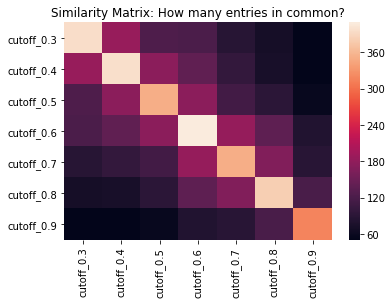

In [90]:
sns.heatmap(similarity_matrix)
plt.title('Similarity Matrix: How many entries in common?')

In [91]:
percentage_similarity_matrix = similarity_matrix / num_edges

In [92]:
percentage_similarity_matrix

,cutoff_0.3,cutoff_0.4,cutoff_0.5,cutoff_0.6,cutoff_0.7,cutoff_0.8,cutoff_0.9
cutoff_0.3,1.000000,0.465995,0.349432,0.295844,0.247159,0.183246,0.160883
cutoff_0.4,0.468354,1.000000,0.497159,0.339853,0.278409,0.191099,0.157729
cutoff_0.5,0.311392,0.440806,1.000000,0.427873,0.318182,0.240838,0.182965
cutoff_0.6,0.306329,0.350126,0.497159,1.000000,0.522727,0.358639,0.258675
cutoff_0.7,0.220253,0.246851,0.318182,0.449878,1.000000,0.437173,0.280757
cutoff_0.8,0.177215,0.183879,0.261364,0.334963,0.474432,1.000000,0.375394
cutoff_0.9,0.129114,0.125945,0.164773,0.200489,0.252841,0.311518,1.000000


Text(0.5,1,'percentage similar')

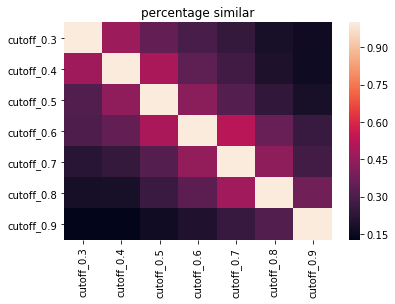

In [93]:
sns.heatmap(percentage_similarity_matrix)
plt.title('percentage similar')

In [55]:
def get_symbol(fbgn_id):
    if fbgn_id in gene_id_to_sym.keys():
        return gene_id_to_sym[fbgn_id]
    return fbgn_id

In [47]:
## Send to gephi outputs:
for k in networks_symbols_high_conf:
    to_gephi_net = networks_symbols_high_conf[k].copy()
    to_gephi_net['Target'] = [get_symbol(i) for i in to_gephi_net['target']]
    to_gephi_net['Source'] = [get_symbol(i) for i in to_gephi_net['regulator']]
    to_gephi_net = to_gephi_net.drop(['target', 'regulator'], axis=1)
    to_gephi_net.to_csv(os.path.join(output_dir, '{}_to_gephi_network.tsv'.format(k)), sep='\t', index_col=0, index=False)

In [48]:
networks_symbols_high_conf.keys()

['cutoff_0.6',
 'cutoff_0.7',
 'cutoff_0.4',
 'cutoff_0.5',
 'cutoff_0.3',
 'cutoff_0.8',
 'cutoff_0.9']

## New Analysis of KNN Smoothed outputs

In [23]:
output_dir = '/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/network_inputs_and_outputs/outputs/WtJ_and_WtF_KNN_Smoothed_data'  # dmel_TF_filtered_experiment'

In [24]:
first_last_folders =   ['2018-03-27_16-24-05', '2018-03-28_16-19-38'] 
folders = os.listdir(output_dir)
relevant_folders = [i for i in sorted(folders) if (i >= first_last_folders[0]) & (i <= first_last_folders[1])]
relevant_folders


['2018-03-27_16-24-05',
 '2018-03-28_12-57-21',
 '2018-03-28_13-49-36',
 '2018-03-28_16-19-38']

In [25]:
# Generate networks
networks = {}
basename = 'knn_'
knns = [10, 7, 5, 3]
for idx, i in enumerate(relevant_folders):
    filename = os.path.join(os.path.join(output_dir, i), 'network.tsv')
    name = basename + str(knns[idx])
    networks[name] = pd.read_csv(filename, sep='\t')
    networks[name].head()
    


knn_10
60.0


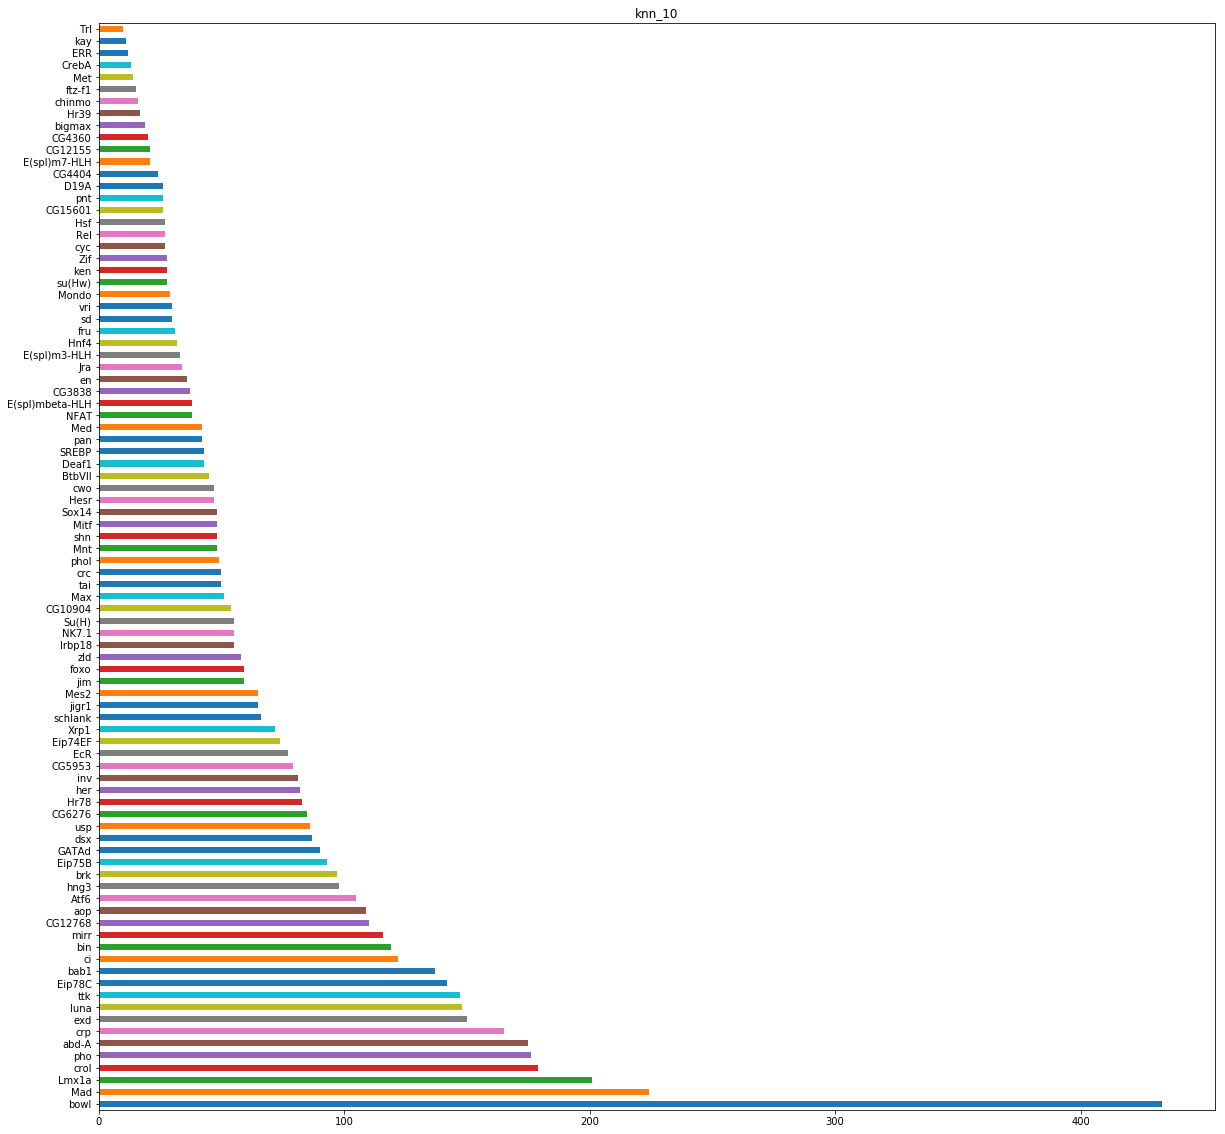

knn_3
60.0


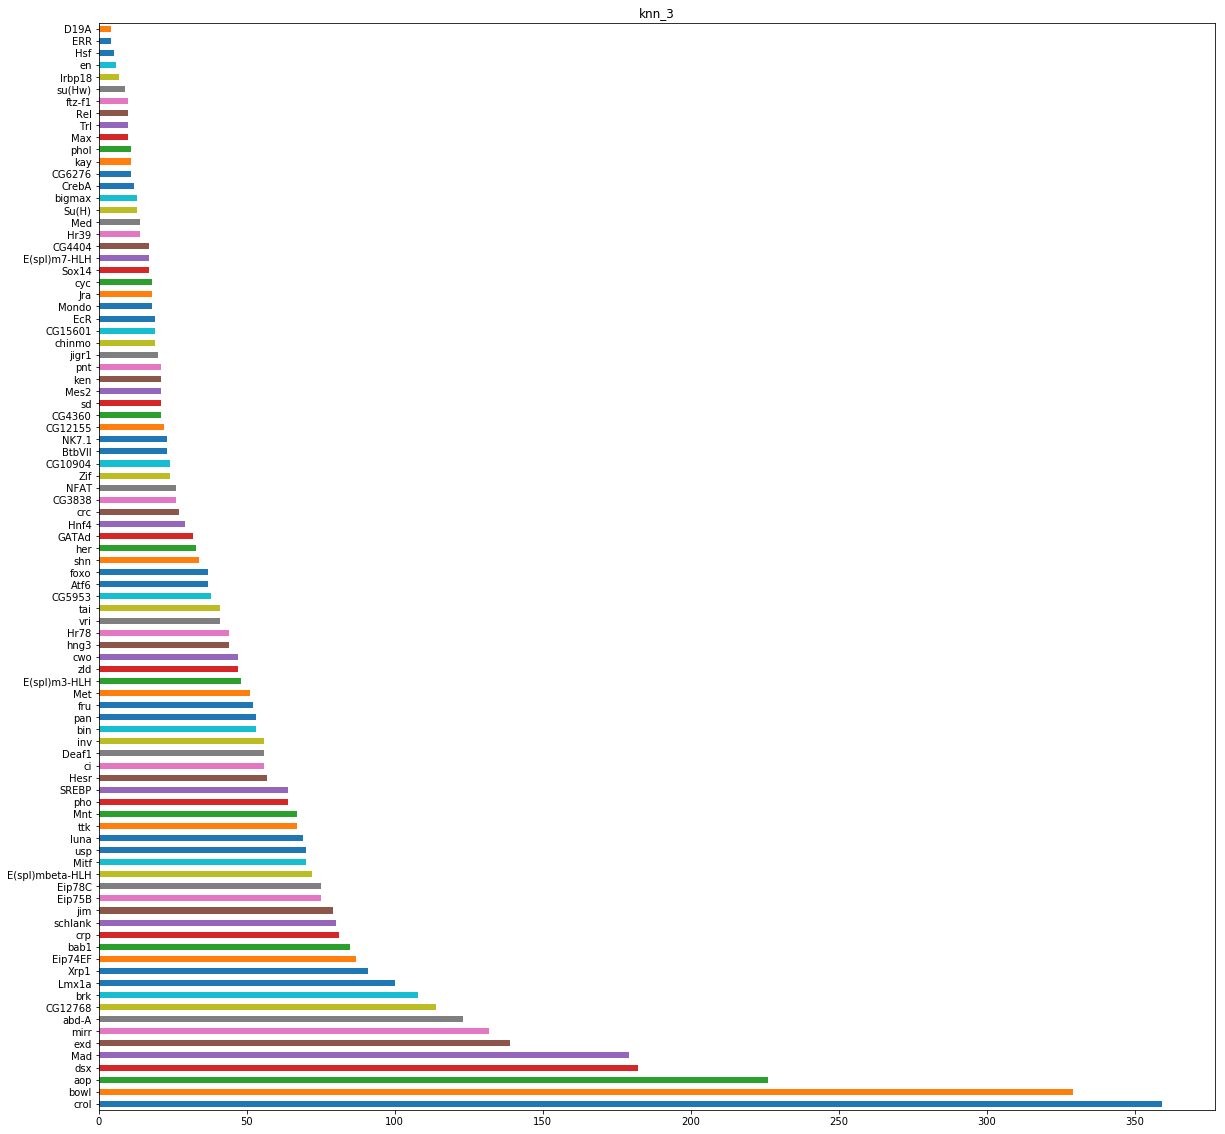

knn_5
60.0


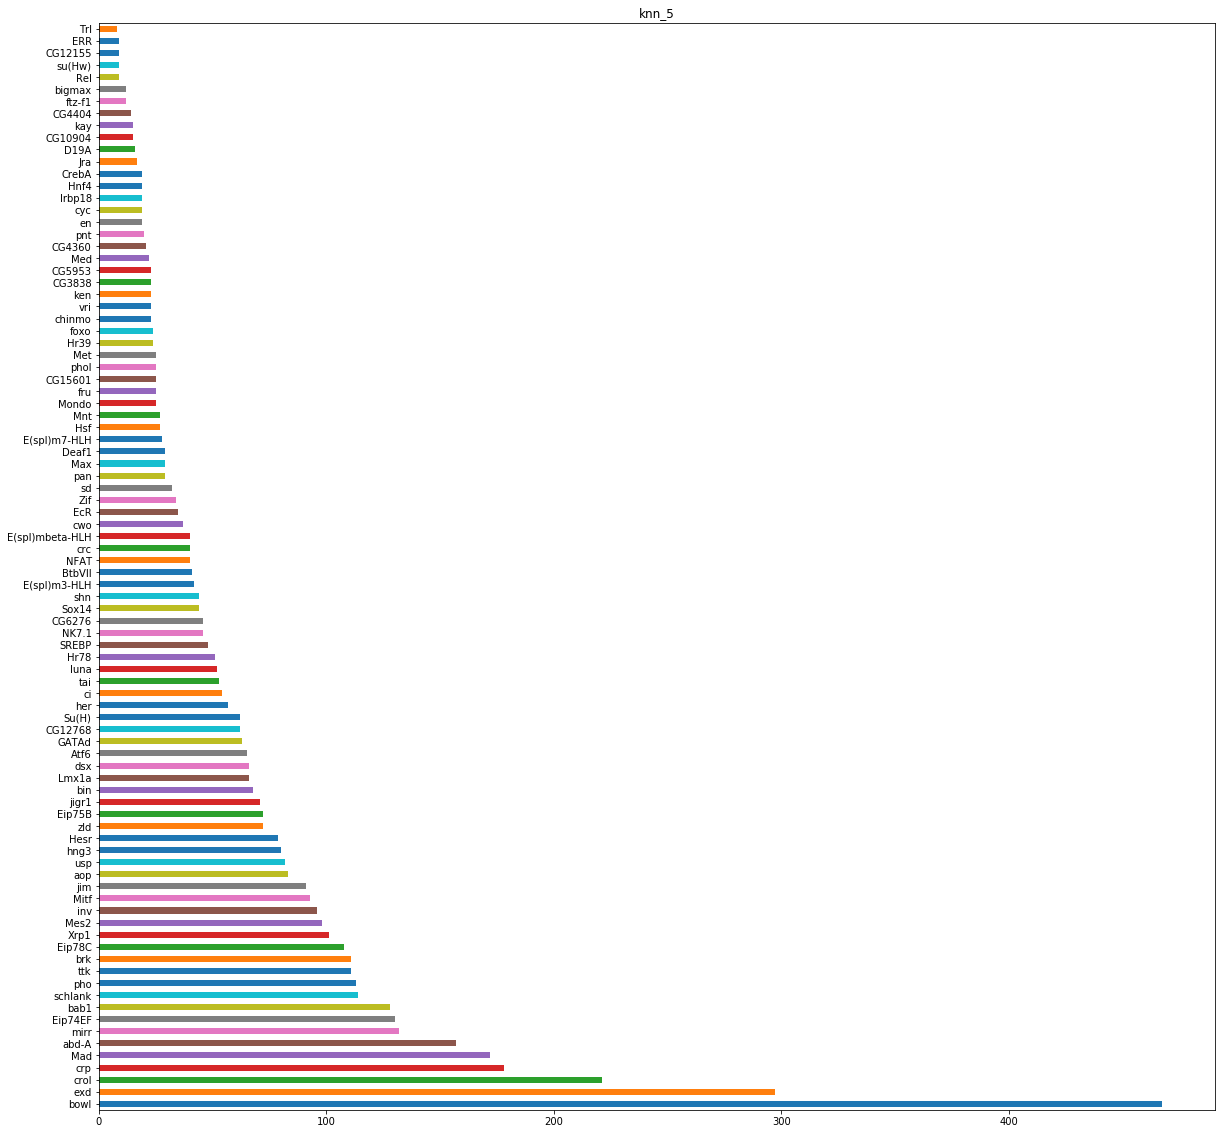

knn_7
60.0


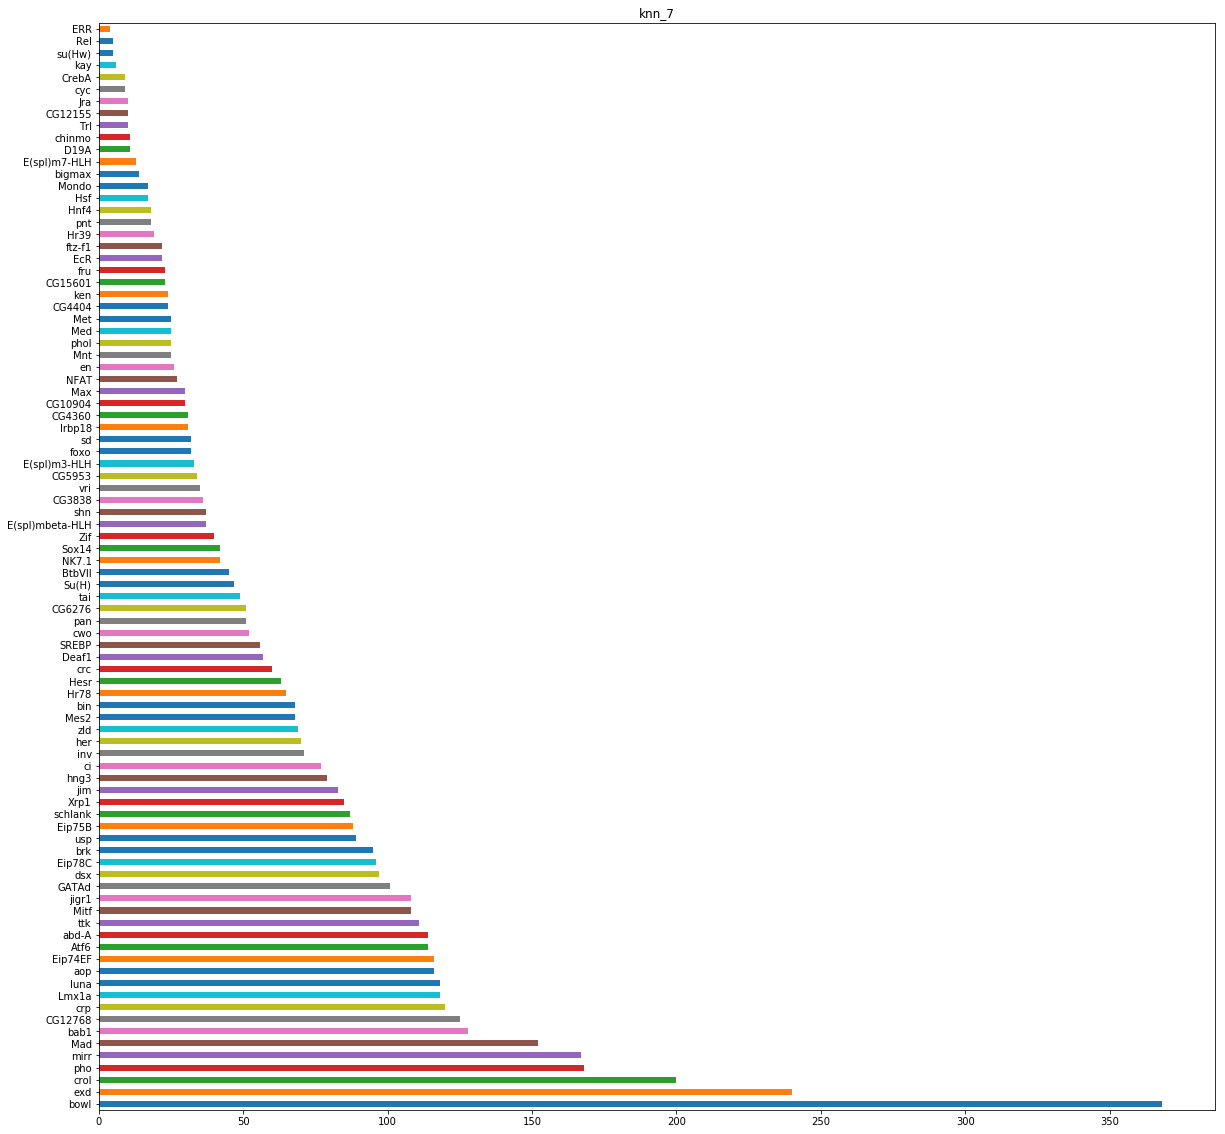

In [27]:
num_regulators = []
num_targets = []
num_edges = []
networks_symbols_high_conf = {}
for k in sorted(networks.keys()):
    plt.figure(figsize=(20,20))
    print k
    max_b  = np.max(networks[k]['beta.non.zero'])
    print(max_b)
    # High confidence net built from more than 50% betas
    net = networks[k][networks[k]['beta.non.zero'] >= max_b / 2]
    networks_symbols_high_conf[k] = net.copy()
    networks_symbols_high_conf[k]['regulator'] = convert_col_from_Fbgn_ids_to_symbols(net['regulator'])
    networks_symbols_high_conf[k]['target'] = convert_col_from_Fbgn_ids_to_symbols(net['target'])
    regs = set(net['regulator'])
    targets = set(net['target'])    
    num_edges.append(net.shape[0])
    num_regulators.append(len(regs))
    num_targets.append(len(targets))
    some_cols = ['regulator', 'target', 'beta.sign.sum', 'beta.non.zero']
    #print(networks_symbols_high_conf[k][some_cols][networks_symbols_high_conf[k]['target'].isin(terminal_filament_specific_genes)])
    #print(networks_symbols_high_conf[k][some_cols][networks_symbols_high_conf[k]['regulator'].isin(terminal_filament_specific_tfs)])
    vals = networks_symbols_high_conf[k]['regulator'].value_counts()
    vals = vals[vals > 2]
    vals.plot(kind='barh')
    plt.title(k)
    plt.show()
    

In [28]:
# Create side tables
for k in networks_symbols_high_conf:
    vals = networks_symbols_high_conf[k]['regulator'].value_counts()
    vals.to_csv('{}_counts_per_regulator.tsv'.format(k), sep='\t')
    vals = networks_symbols_high_conf[k]['target'].value_counts()
    vals.to_csv('{}_counts_per_target.tsv'.format(k), sep='\t')

[Text(0,0,'knn_10'), Text(0,0,'knn_3'), Text(0,0,'knn_5'), Text(0,0,'knn_7')]

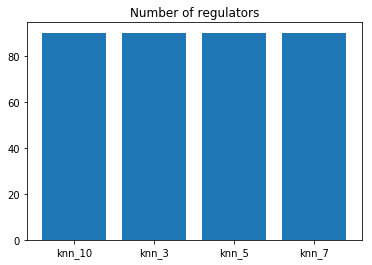

In [157]:
fig, ax = plt.subplots()
plt.title('Number of regulators')
ind = np.arange(1, 5)
ax.bar(ind, num_regulators)
ax.set_xticks(ind)
ax.set_xticklabels(sorted(networks.keys()))

<BarContainer object of 4 artists>

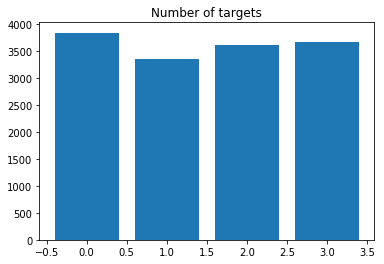

In [158]:
plt.title('Number of targets')
plt.bar(range(4), num_targets, align='center')

In [143]:
networks_symbols_high_conf.values()[0].shape

(5505, 7)

In [159]:
# Compare to each other: how self similar?
similarity_matrix = pd.DataFrame(np.zeros([len(networks), len(networks)]))
similarity_matrix.index = sorted(networks.keys())
similarity_matrix.columns = sorted(networks.keys())    
for k in sorted(networks.keys()):
    print k
    for (idx, row) in networks_symbols_high_conf[k].iterrows():
        src = row['regulator']
        trgt = row['target']
        for j in sorted(networks.keys()):
            if networks_symbols_high_conf[j][(networks_symbols_high_conf[j]['regulator'] == src) & (networks_symbols_high_conf[j]['target'] == trgt)].shape[0] > 0:
                similarity_matrix.loc[j, k] += 1

knn_10
knn_3
knn_5
knn_7


In [160]:
similarity_matrix

,knn_10,knn_3,knn_5,knn_7
knn_10,6258.0,1056.0,1887.0,2148.0
knn_3,1056.0,4829.0,1596.0,1367.0
knn_5,1887.0,1596.0,5505.0,2767.0
knn_7,2148.0,1367.0,2767.0,5629.0


Text(0.5,1,'Similarity Matrix: How many entries in common?')

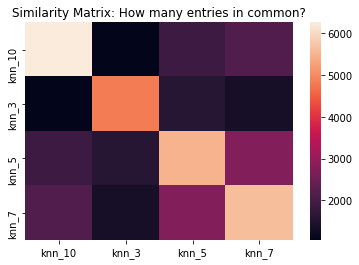

In [161]:
sns.heatmap(similarity_matrix)
plt.title('Similarity Matrix: How many entries in common?')

In [162]:
percentage_similarity_matrix = similarity_matrix / num_edges

Text(0.5,1,'percentage similar')

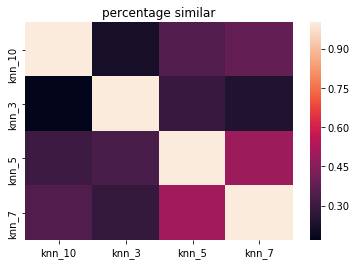

In [163]:
sns.heatmap(percentage_similarity_matrix)
plt.title('percentage similar')

In [60]:
nets = networks_symbols_high_conf.values() # networks_symbols_high_conf
combined_net = pd.concat(nets)

In [61]:
combined_net.shape

(22221, 7)

In [62]:
summed_net = combined_net.groupby(['regulator', 'target']).sum().sum(
    level=['regulator', 'target'])

In [63]:
top_interactions = summed_net.sort_values('beta.non.zero', ascending=False)
top_interactions

beta.sign.sum  beta.non.zero  var.exp.median  \
regulator    target                                                       
bab1         Rsf1                  240.0          240.0        2.708990   
zld          aay                   240.0          240.0        2.640888   
usp          Uhg7                  240.0          240.0        1.939117   
CG5953       CG3838                240.0          240.0        3.112414   
CG3838       CG5953                240.0          240.0        3.340080   
E(spl)m3-HLH E(spl)m2-BFM          240.0          240.0        3.632699   
bowl         14-3-3zeta            239.0          239.0        2.792151   
             GstE12                239.0          239.0        2.435318   
bab1         LanA                  239.0          239.0        2.366428   
Deaf1        Taf4                  239.0          239.0        1.554031   
E(spl)m3-HLH Hesr                  239.0          239.0        3.290508   
brk          Ten-a                 238.0          238.0        2.042965   
zld          Ect4                  238.0          238.0        2.129134   
cyc          CG3262                238.0          238.0        1.622979   
Xrp1         Moe                   238.0          238.0        2.528514   
usp          flw                   238.0          238.0        1.858224   
aop          skd                   238.0          238.0        2.731047   
jim          CG10543               238.0          238.0        1.529163   
brk          rho                   237.0          237.0        1.950712   
Atf6         CG32202               237.0          237.0        1.358780   
Xrp1         Chd64                 236.0          236.0        2.933367   
exd          CG5969                236.0          236.0        1.779182   
mirr         CG40160               236.0          236.0        1.968762   
             CG6766                236.0          236.0        2.371606   
brk          pum                   235.0          235.0        1.876520   
Hesr         E(spl)m3-HLH          235.0          235.0        2.847111   
bowl         RNASEK                235.0          235.0        2.866287   
crol         Hrb27C                235.0          235.0        2.131557   
mirr         CG14945               235.0          235.0        2.378057   
aop          tna                   235.0          235.0        3.259096   
...                                  ...            ...             ...   
shn          RpL5                   30.0           30.0        0.126335   
crc          glec                   30.0           30.0        0.065576   
bowl         Vha13                  30.0           30.0        0.165301   
EcR          Ucp4A                  30.0           30.0        0.043413   
Mitf         Ssb-c31a               30.0           30.0        0.053286   
EcR          Rpn7                   30.0           30.0        0.059758   
pho          emb                    30.0           30.0        0.075438   
             ebd1                   30.0           30.0        0.061729   
Mitf         CG15107                30.0           30.0        0.058425   
Met          magu                   30.0           30.0        0.049304   
bowl         mRpL22                 30.0           30.0        0.069249   
pho          alc                    30.0           30.0        0.063312   
ttk          Qtzl                   30.0           30.0        0.034002   
Hr78         CG18004                30.0           30.0        0.041589   
fru          CG5126                 30.0           30.0        0.048215   
             CG5390                 30.0           30.0        0.064465   
crp          eIF3e                  30.0           30.0        0.077495   
crc          Sin3A                  30.0           30.0        0.105399   
crp          eIF3g1                 30.0           30.0        0.106220   
fru          Gbp2                  -30.0           30.0        0.040656   
Mitf         CG1628                 30.0           3

In [48]:
mat_file = 'wtJ_TF_cells_k_7.tsv' #'combined_wtJ_and_wtF_TF_cells_smoothed_separately_with_k_7.tsv'
expression_data_just_wtj = pd.read_csv(os.path.join(output_dir, mat_file), sep='\t', index_col  = 0) #sep='\t',
mat_file = 'combined_wtJ_and_wtF_TF_cells_smoothed_separately_with_k_7.tsv'
expression_data = pd.read_csv(os.path.join(output_dir, mat_file), sep='\t', index_col  = 0) #sep='\t',


In [49]:
expression_data_just_wtj.head()

,AACTCCCTCCCGACTT-1,AAGGAGCGTTCCATGA-1,ACCAGTAAGCTAACAA-1,ACCTTTAGTGCAGGTA-1,ACGAGGAGTGGCTCCA-1,ACGATGTCATTTCACT-1,ACGCCAGGTTCAGTAC-1,ACGTCAACAATGTAAG-1,ACTTACTGTCCGACGT-1,ACTTACTTCGCAGGCT-1,...,TGACAACGTACGACCC-1,TGACTTTCAGACGCTC-1,TGCACCTCAAGCTGGA-1,TGCACCTTCACAACGT-1,TGCCAAACATTCGACA-1,TGGCGCACAGCATGAG-1,TGGCGCACAGCCACCA-1,TGTCCCATCCAATGGT-1,TTCGGTCAGAGCTGCA-1,TTGTAGGGTTGGACCC-1
FBgn0085412,11,43,33,19,17,17,28,15,41,21,...,20,19,15,17,17,15,27,17,21,21
FBgn0039265,23,38,25,33,19,24,33,17,25,17,...,15,23,17,19,24,27,53,19,17,17
FBgn0039532,2,7,4,4,2,1,5,2,5,2,...,1,3,2,2,1,3,5,2,1,1
FBgn0003046,10,16,40,15,7,7,8,7,26,27,...,28,10,7,12,7,31,8,7,26,26
FBgn0038274,2,0,6,2,0,0,1,1,0,3,...,4,1,1,1,0,5,2,0,5,5


In [220]:
expression_data[expression_data_just_wtj.columns].head()

,AACTCCCTCCCGACTT-1,AAGGAGCGTTCCATGA-1,ACCAGTAAGCTAACAA-1,ACCTTTAGTGCAGGTA-1,ACGAGGAGTGGCTCCA-1,ACGATGTCATTTCACT-1,ACGCCAGGTTCAGTAC-1,ACGTCAACAATGTAAG-1,ACTTACTGTCCGACGT-1,ACTTACTTCGCAGGCT-1,...,TGACAACGTACGACCC-1,TGACTTTCAGACGCTC-1,TGCACCTCAAGCTGGA-1,TGCACCTTCACAACGT-1,TGCCAAACATTCGACA-1,TGGCGCACAGCATGAG-1,TGGCGCACAGCCACCA-1,TGTCCCATCCAATGGT-1,TTCGGTCAGAGCTGCA-1,TTGTAGGGTTGGACCC-1
FBgn0085412,11,43,33,19,17,17,28,15,41,21,...,20,19,15,17,17,15,27,17,21,21
FBgn0039265,23,38,25,33,19,24,33,17,25,17,...,15,23,17,19,24,27,53,19,17,17
FBgn0039532,2,7,4,4,2,1,5,2,5,2,...,1,3,2,2,1,3,5,2,1,1
FBgn0003046,10,16,40,15,7,7,8,7,26,27,...,28,10,7,12,7,31,8,7,26,26
FBgn0038274,2,0,6,2,0,0,1,1,0,3,...,4,1,1,1,0,5,2,0,5,5


In [214]:
expression_data.head()

,AAACCTGTCCGCAGTG-1,AAAGTAGCAGACGCAA-1,AACGTTGTCTCCAACC-1,AACTCCCAGTGCCAGA-1,AAGACCTTCTCTGCTG-1,AAGTCTGTCCCTGACT-1,AATCCAGGTTATTCTC-1,ACACCAAAGCTTCGCG-1,ACACCAATCACCGGGT-1,ACGCAGCGTCGACTAT-1,...,TGACAACGTACGACCC-1,TGACTTTCAGACGCTC-1,TGCACCTCAAGCTGGA-1,TGCACCTTCACAACGT-1,TGCCAAACATTCGACA-1,TGGCGCACAGCATGAG-1,TGGCGCACAGCCACCA-1,TGTCCCATCCAATGGT-1,TTCGGTCAGAGCTGCA-1,TTGTAGGGTTGGACCC-1
FBgn0085412,11,28,14,17,9,17,11,10,18,17,...,20,19,15,17,17,15,27,17,21,21
FBgn0039265,12,38,24,20,9,28,24,30,41,28,...,15,23,17,19,24,27,53,19,17,17
FBgn0039532,2,13,2,3,2,4,4,9,7,5,...,1,3,2,2,1,3,5,2,1,1
FBgn0003046,16,35,25,17,15,3,25,4,1,3,...,28,10,7,12,7,31,8,7,26,26
FBgn0038274,2,4,3,4,2,2,2,3,2,2,...,4,1,1,1,0,5,2,0,5,5


In [206]:
import seaborn as sns

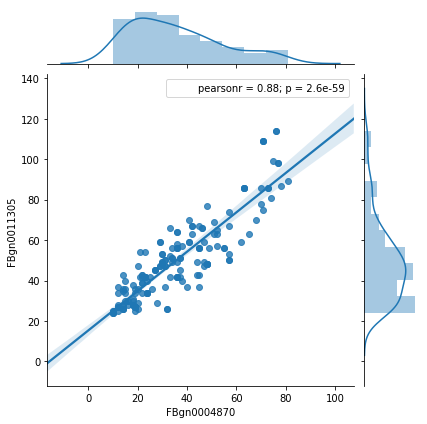

In [52]:
sns.jointplot('FBgn0004870', 'FBgn0011305', expression_data.transpose(), kind='reg')

//anaconda/envs/py27.13/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


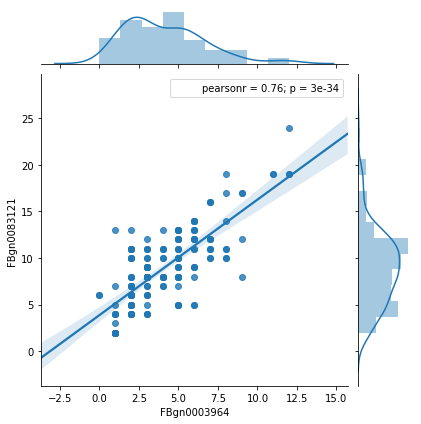

In [50]:
sns.jointplot('FBgn0003964', 'FBgn0083121', expression_data.transpose(), kind='reg')

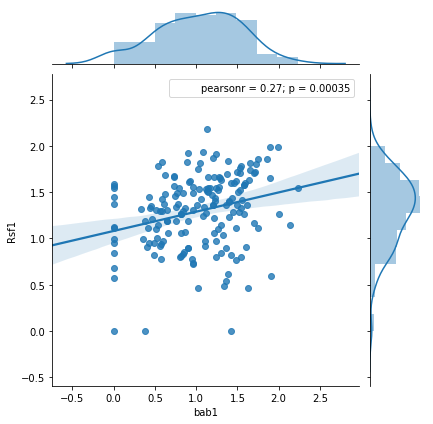

In [223]:
matrices_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/network_inputs_and_outputs/inputs/03_02_2018"
mat_file = 'TF_data.csv'
cca_data = pd.read_csv(os.path.join(matrices_dir, mat_file), sep=',', index_col  = 0) #sep='\t',
g = sns.jointplot("bab1", "Rsf1", data=cca_data.transpose(), kind="reg")

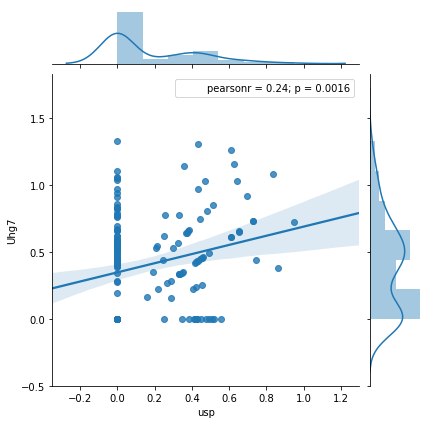

In [51]:
matrices_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/network_inputs_and_outputs/inputs/03_02_2018"
mat_file = 'TF_data.csv'
cca_data = pd.read_csv(os.path.join(matrices_dir, mat_file), sep=',', index_col  = 0) #sep='\t',
g = sns.jointplot("usp", "Uhg7", data=cca_data.transpose(), kind="reg")

In [194]:
fname = "inferelator_network_shared_across_WtF_and_WtJ_Fbgn_knn_3_5_7_10.tsv"
top_interactions.to_csv(fname, sep='\t')

In [195]:
inters = pd.read_csv(fname, sep = '\t')

In [208]:
inters.head()

,regulator,target,beta.sign.sum,beta.non.zero,var.exp.median,combined_confidences,prior
0,FBgn0003964,FBgn0083121,240.0,240.0,1.939117,3.981903,4.0
1,FBgn0002609,FBgn0002592,240.0,240.0,3.632699,3.999967,4.0
2,FBgn0004870,FBgn0011305,240.0,240.0,2.708990,3.996439,0.0
3,FBgn0259789,FBgn0023129,240.0,240.0,2.640888,3.993335,4.0
4,FBgn0032587,FBgn0032130,240.0,240.0,3.112414,3.998585,0.0


In [122]:
for k in networks_symbols_high_conf:
    
    networks_symbols_high_conf[k].to_csv("inferelator_network_for_{}.tsv".format(k), sep='\t')
    

In [176]:
inters.head()

,regulator,target,beta.sign.sum,beta.non.zero,var.exp.median,combined_confidences,prior
0,bab1,Rsf1,240.0,240.0,2.708990,3.996439,0.0
1,zld,aay,240.0,240.0,2.640888,3.993335,4.0
2,usp,Uhg7,240.0,240.0,1.939117,3.981903,4.0
3,CG5953,CG3838,240.0,240.0,3.112414,3.998585,0.0
4,CG3838,CG5953,240.0,240.0,3.340080,3.998838,0.0


## New analysis of Marbach prior outputs

In [10]:
output_dir = '/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/network_inputs_and_outputs/outputs/Marbach_prior_wtJ_and_WtF_KNN_Smoothed'  # dmel_TF_filtered_experiment'

In [11]:
first_last_folders =   ['2018-04-04_08-53-55', '2018-04-04_08-53-55']  # only one folder for now
folders = os.listdir(output_dir)
relevant_folders = [i for i in sorted(folders) if (i >= first_last_folders[0]) & (i <= first_last_folders[1])]
relevant_folders


['2018-04-04_08-53-55']

In [13]:
# Generate networks
networks = {}
basename = 'knn_'
knns = [3]
for idx, i in enumerate(relevant_folders):
    filename = os.path.join(os.path.join(output_dir, i), 'network.tsv')
    name = basename + str(knns[idx])
    networks[name] = pd.read_csv(filename, sep='\t')
    networks[name].head()
    


knn_3
        regulator   target  beta.sign.sum  beta.non.zero
24          Asciz   CG2852           60.0           60.0
59           HHEX   Mur89F           59.0           59.0
164           zld       Dl           53.0           53.0
165          CTCF       Dl           53.0           53.0
297           run  Dh44-R2           49.0           49.0
324         CrebA     glec           48.0           48.0
476            E5    ImpE1           44.0           44.0
847          slbo    ImpE1           38.0           38.0
1424  FBgn0011764     glec           32.0           32.0
1657         slbo     Gbp1           30.0           30.0
     regulator     target  beta.sign.sum  beta.non.zero
13        bab2       Wnt4           60.0           60.0
311         en    CG43736           48.0           48.0
353         en     REPTOR           47.0           47.0
563         en      NK7.1           43.0           43.0
776         en        aop           39.0           39.0
1300        en        chn      

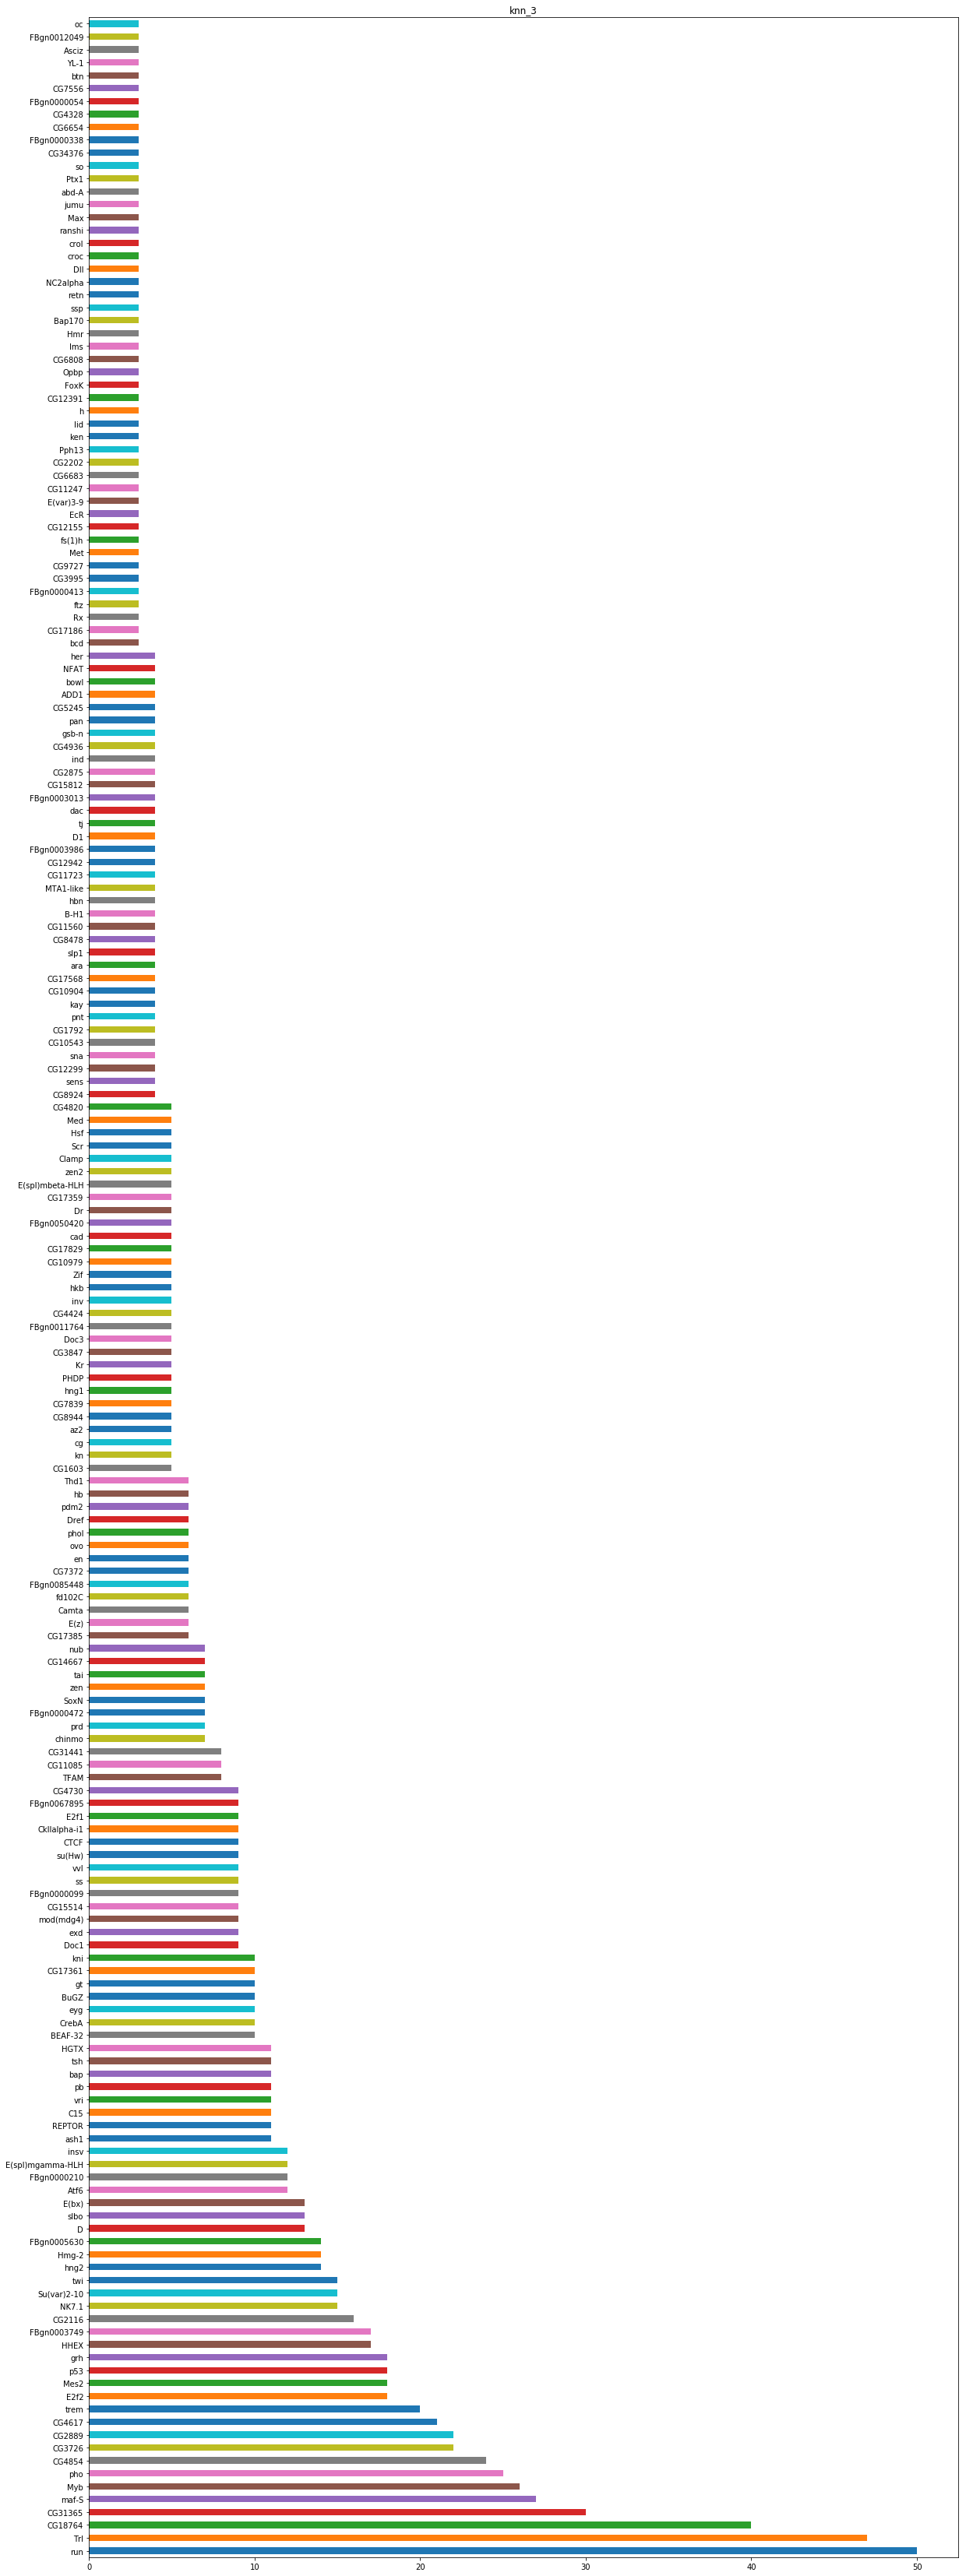

In [45]:
num_regulators = []
num_targets = []
num_edges = []
networks_symbols_high_conf = {}
for k in sorted(networks.keys()):
    plt.figure(figsize=(20,60))
    print k
    net = networks[k][networks[k]['beta.non.zero'] >= 30]
    networks_symbols_high_conf[k] = net.copy()
    networks_symbols_high_conf[k]['regulator'] = convert_col_from_Fbgn_ids_to_symbols(net['regulator'])
    networks_symbols_high_conf[k]['target'] = convert_col_from_Fbgn_ids_to_symbols(net['target'])
    regs = set(net['regulator'])
    targets = set(net['target'])    
    num_edges.append(net.shape[0])
    num_regulators.append(len(regs))
    num_targets.append(len(targets))
    some_cols = ['regulator', 'target', 'beta.sign.sum', 'beta.non.zero']
    print(networks_symbols_high_conf[k][some_cols][networks_symbols_high_conf[k]['target'].isin(terminal_filament_specific_genes)])
    print(networks_symbols_high_conf[k][some_cols][networks_symbols_high_conf[k]['regulator'].isin(terminal_filament_specific_tfs)])
    vals = networks_symbols_high_conf[k]['regulator'].value_counts()
    vals = vals[vals > 2]
    vals.plot(kind='barh')
    plt.title(k)
    plt.show()

[Text(0,0,'knn_3')]

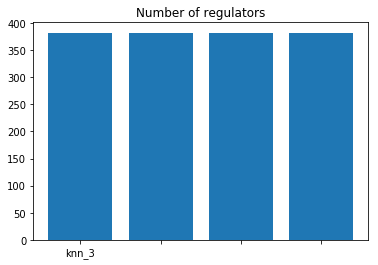

In [20]:
fig, ax = plt.subplots()
plt.title('Number of regulators')
ind = np.arange(1, 5)
ax.bar(ind, num_regulators)
ax.set_xticks(ind)
ax.set_xticklabels(sorted(networks.keys()))

In [26]:
networks[k]
summed_net = networks[k]
top_interactions = summed_net.sort_values('beta.non.zero', ascending=False)[summed_net['beta.non.zero'] >= 20][summed_net['prior'] == 0]
top_interactions

,regulator,target,beta.sign.sum,beta.non.zero,var.exp.median,combined_confidences,prior
0,FBgn0000014,FBgn0004620,60.0,60.0,1.000000,0.999998,1.0
1,FBgn0036274,FBgn0004620,60.0,60.0,1.000000,0.999998,1.0
2,FBgn0014179,FBgn0086472,60.0,60.0,0.995433,0.999993,1.0
3,FBgn0000629,FBgn0034138,60.0,60.0,0.990766,0.999986,1.0
4,FBgn0039712,FBgn0014026,60.0,60.0,0.989568,0.999984,1.0
5,FBgn0039712,FBgn0010265,60.0,60.0,0.989557,0.999984,1.0
6,FBgn0026160,FBgn0038826,60.0,60.0,0.989227,0.999982,1.0
7,FBgn0030990,FBgn0003517,60.0,60.0,0.988578,0.999981,1.0
8,FBgn0034599,FBgn0034968,60.0,60.0,0.983929,0.999964,1.0
9,FBgn0050420,FBgn0028342,60.0,60.0,0.979639,0.999952,1.0


In [36]:
recovered_prior = summed_net.sort_values('beta.non.zero', ascending=False)[summed_net['prior'] != 0]
recovered_prior

/anaconda/envs/py27.13/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,regulator,target,beta.sign.sum,beta.non.zero,var.exp.median,combined_confidences,prior
0,FBgn0000014,FBgn0004620,60.0,60.0,1.000000,0.999998,1.0
33,FBgn0037207,FBgn0031769,60.0,60.0,0.635654,0.999055,1.0
24,FBgn0035407,FBgn0034753,60.0,60.0,0.782745,0.999726,1.0
25,FBgn0004054,FBgn0051676,60.0,60.0,0.779703,0.999721,1.0
26,FBgn0000338,FBgn0003884,60.0,60.0,0.771316,0.999719,1.0
29,FBgn0003028,FBgn0000261,60.0,60.0,0.648015,0.999449,1.0
31,FBgn0038805,FBgn0001224,60.0,60.0,0.568011,0.999244,1.0
32,FBgn0005638,FBgn0003447,60.0,60.0,0.540575,0.999070,1.0
34,FBgn0003345,FBgn0052594,60.0,60.0,0.474586,0.998651,1.0
22,FBgn0261239,FBgn0037624,60.0,60.0,0.850400,0.999758,1.0


In [37]:
recovered_prior.shape

(24745, 7)

In [41]:
np.sum(sup_table.sum())

285889.0

In [40]:
# Cut out prior values from the marbach gold standard
for (idx, row) in recovered_prior.iterrows():
    sup_table.loc[row['target'], row['regulator']] = 0

## Analysis of Embryo against Marbach

In [12]:
output_dir = '/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/embryo_network'

In [13]:
first_last_folders =   ['2018-05-04_07-05-48_knn3_10_bootstraps',  '2018-05-07_04-40-55_knn5_20_bootstraps'] 
folders = os.listdir(output_dir)
relevant_folders = [i for i in sorted(folders) if (i >= first_last_folders[0]) & (i <= first_last_folders[1])]
relevant_folders

['2018-05-04_07-05-48_knn3_10_bootstraps',
 '2018-05-04_14-31-31_no_smoothing',
 '2018-05-07_04-40-55_knn5_20_bootstraps']

In [14]:
# Generate networks
networks = {}
basename = 'knn_'
knns = [3, 0, 5]
for idx, i in enumerate(relevant_folders):
    filename = os.path.join(os.path.join(output_dir, i), 'network.tsv')
    name = basename + str(knns[idx])
    networks[name] = pd.read_csv(filename, sep='\t')
    networks[name].head()
    

knn_0
20.0


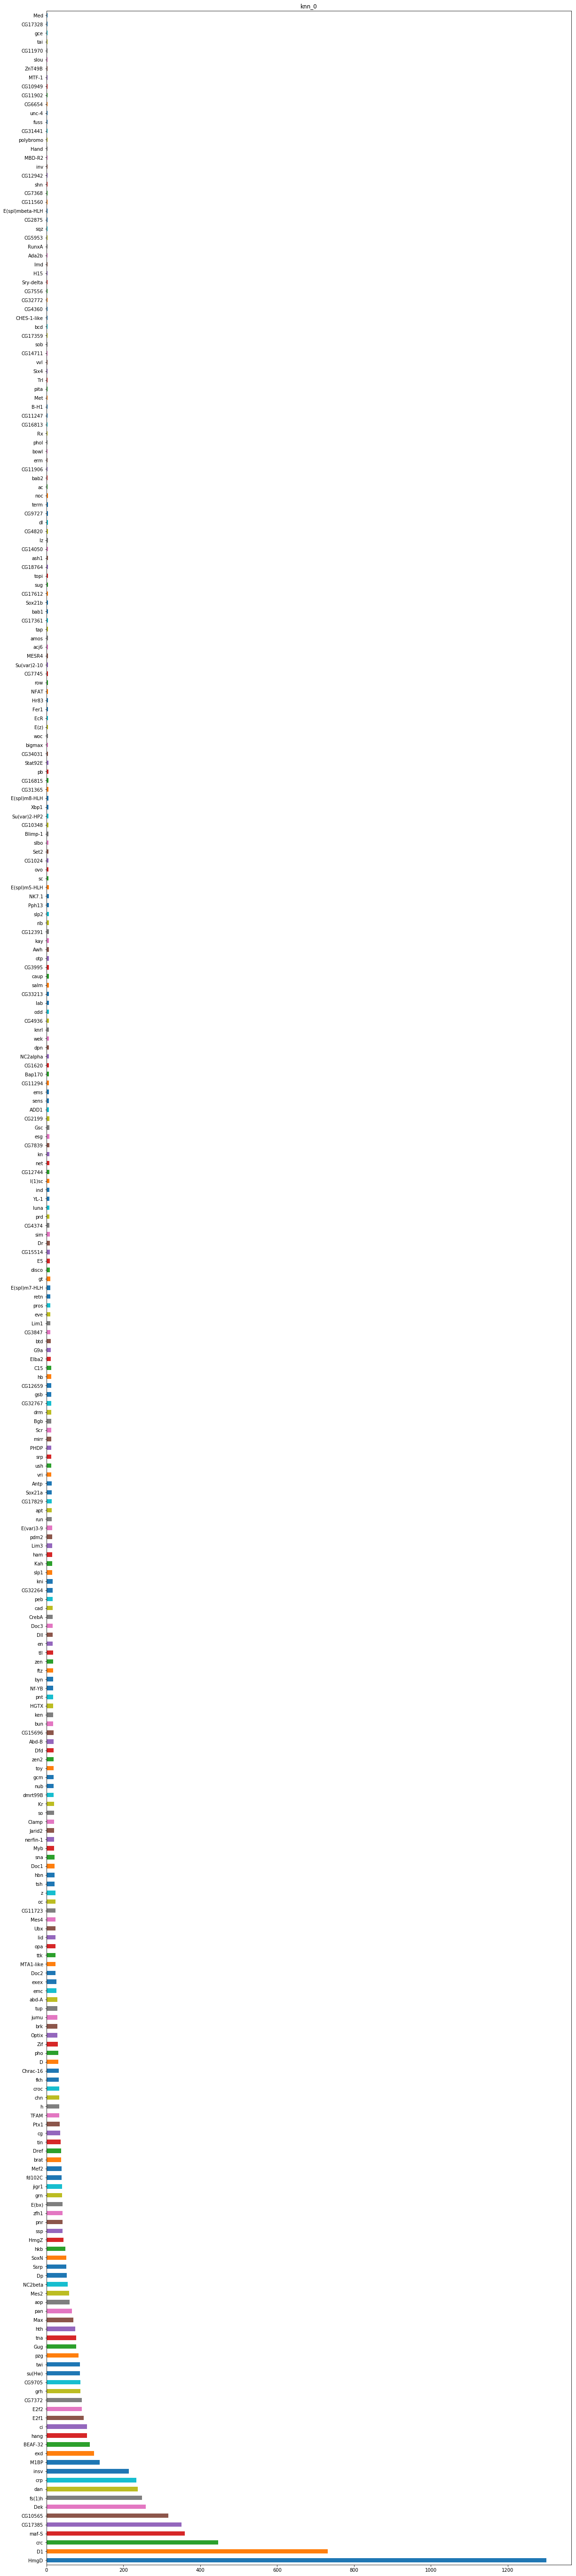

knn_3
10.0


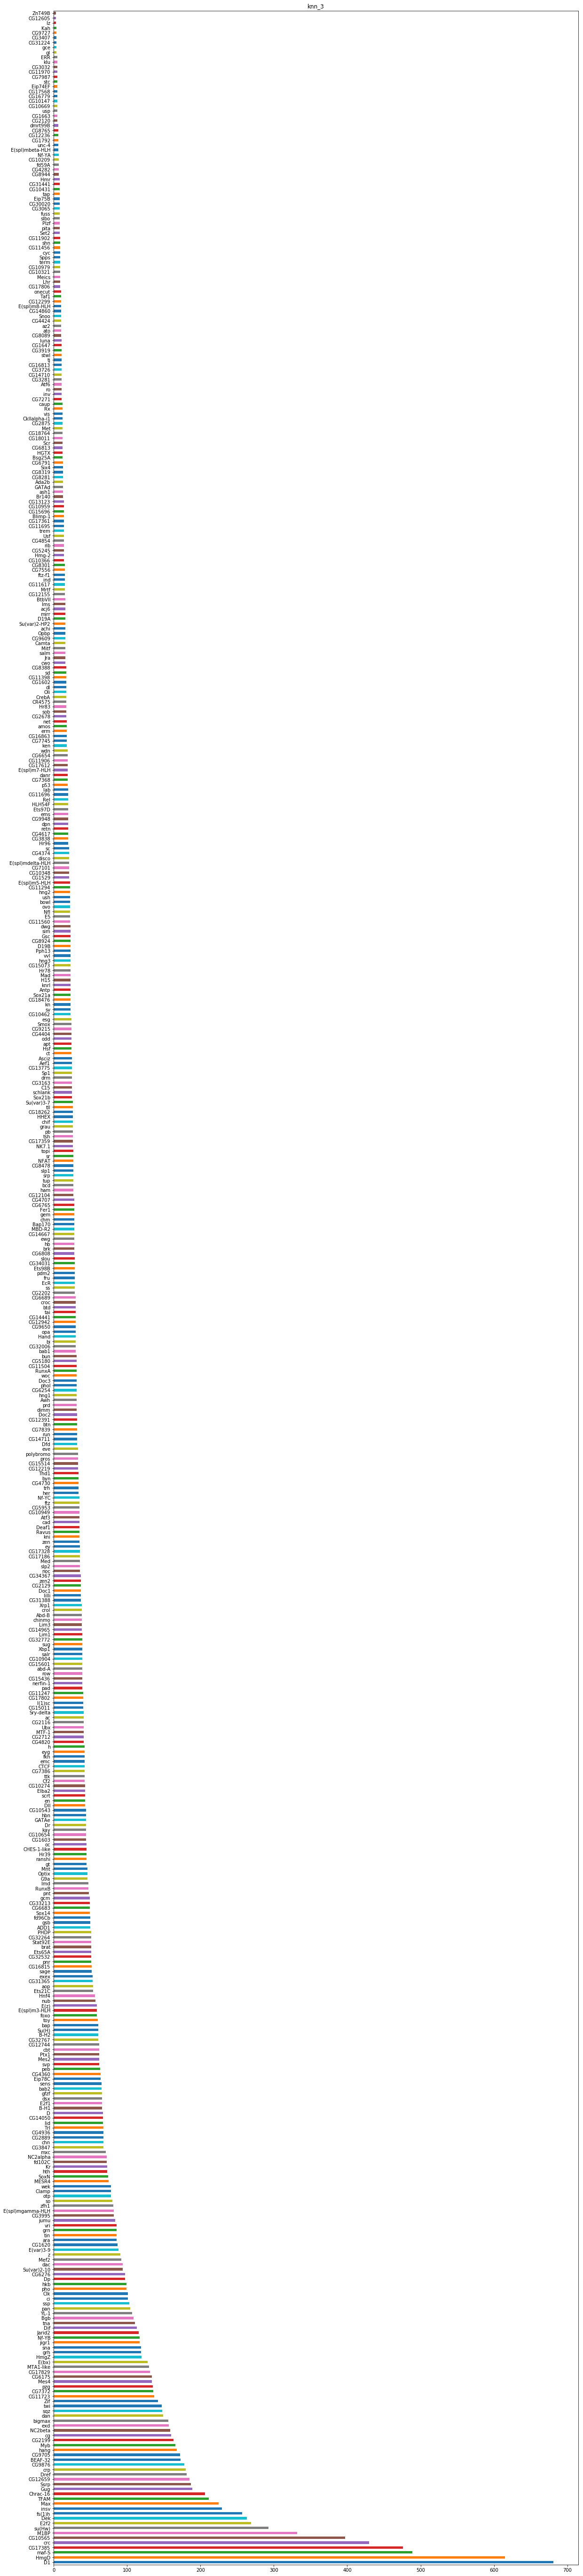

knn_5
20.0


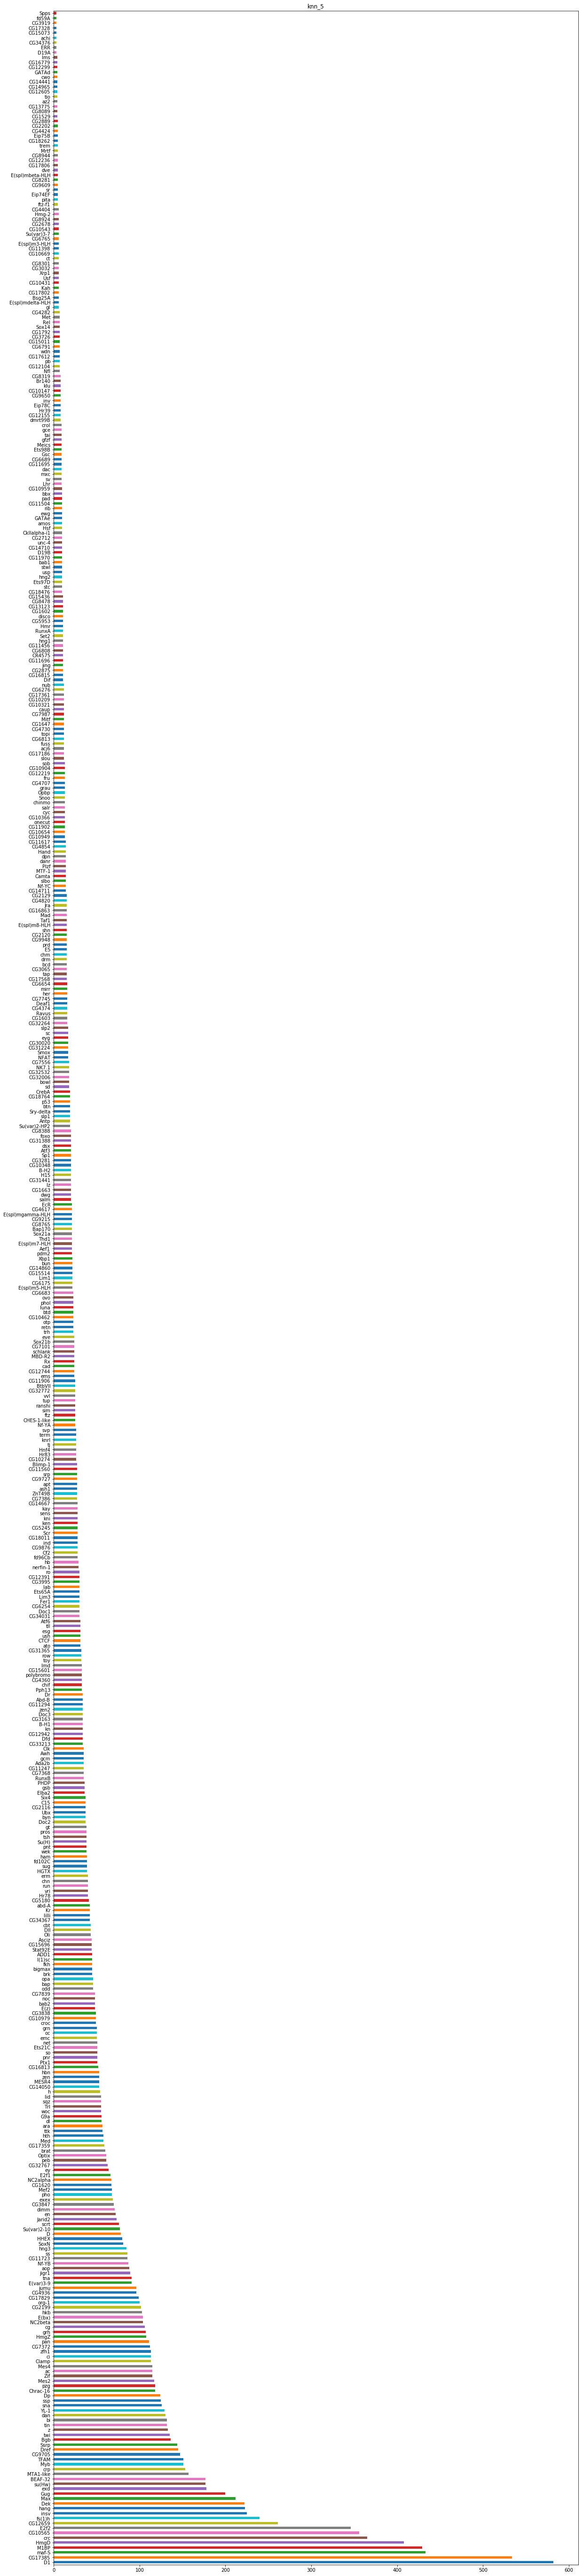

In [18]:
num_regulators = []
num_targets = []
num_edges = []
networks_symbols_high_conf = {}
for k in sorted(networks.keys()):
    plt.figure(figsize=(20,100))
    print k
    max_b  = np.max(networks[k]['beta.non.zero'])
    print(max_b)
    # High confidence net built from more than 50% betas
    net = networks[k][networks[k]['beta.non.zero'] >= max_b / 2]
    networks_symbols_high_conf[k] = net.copy()
    networks_symbols_high_conf[k]['regulator'] = convert_col_from_Fbgn_ids_to_symbols(net['regulator'])
    networks_symbols_high_conf[k]['target'] = convert_col_from_Fbgn_ids_to_symbols(net['target'])
    regs = set(net['regulator'])
    targets = set(net['target'])    
    num_edges.append(net.shape[0])
    num_regulators.append(len(regs))
    num_targets.append(len(targets))
    some_cols = ['regulator', 'target', 'beta.sign.sum', 'beta.non.zero']
    vals = networks_symbols_high_conf[k]['regulator'].value_counts()
    vals = vals[vals > 2]
    vals.plot(kind='barh')
    plt.title(k)
    plt.show()

[Text(0,0,'knn_0'), Text(0,0,'knn_3'), Text(0,0,'knn_5')]

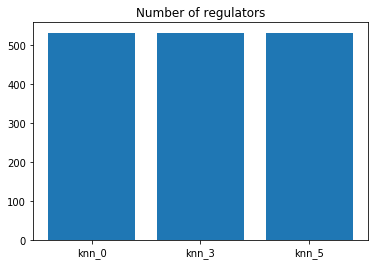

In [16]:
fig, ax = plt.subplots()
plt.title('Number of regulators')
ind = np.arange(1, 4)
ax.bar(ind, num_regulators)
ax.set_xticks(ind)
ax.set_xticklabels(sorted(networks.keys()))

In [21]:
# Create side tables
for k in networks_symbols_high_conf:
    vals = networks_symbols_high_conf[k]['regulator'].value_counts()
    vals.to_csv('{}_counts_per_regulator.tsv'.format(k), sep='\t')
    vals = networks_symbols_high_conf[k]['target'].value_counts()
    vals.to_csv('{}_counts_per_target.tsv'.format(k), sep='\t')

In [19]:
networks_symbols_high_conf

{'knn_0':          regulator        target  beta.sign.sum  beta.non.zero  \
 0             SoxN           ths           20.0           20.0   
 1     E(spl)m7-HLH           sim           20.0           20.0   
 2             HmgD    Su(var)205           20.0           20.0   
 3              grn       CR43302           20.0           20.0   
 4             HmgD          HmgZ           20.0           20.0   
 5             HmgZ          HmgD           20.0           20.0   
 6             HmgD           baf           20.0           20.0   
 7     E(spl)m7-HLH  E(spl)m8-HLH           20.0           20.0   
 8             knrl           kni           20.0           20.0   
 9             zfh1          NetB           20.0           20.0   
 10             sim  E(spl)m7-HLH           20.0           20.0   
 11            slp1          slp2           20.0           20.0   
 12             brk          SoxN           20.0           20.0   
 13             kni          knrl           20.0     

In [30]:
# Compare to each other: how self similar?
similarity_matrix = pd.DataFrame(np.zeros([len(networks), len(networks)]))
similarity_matrix.index = sorted(networks.keys())
similarity_matrix.columns = sorted(networks.keys())    
for k in sorted(networks.keys()):
    print k
    for (idx, row) in networks_symbols_high_conf[k].iterrows():
        src = row['regulator']
        trgt = row['target']
        for j in sorted(networks.keys()):
            if networks_symbols_high_conf[j][(networks_symbols_high_conf[j]['regulator'] == src) & (networks_symbols_high_conf[j]['target'] == trgt)].shape[0] > 0:
                similarity_matrix.loc[j, k] += 1

knn_0
knn_3
knn_5


In [22]:
networks_symbols_high_conf['knn_5'].to_csv('knn_5_high_conf.tsv', sep='\t')
networks_symbols_high_conf['knn_3'].to_csv('knn_3_high_conf.tsv', sep='\t')
networks_symbols_high_conf['knn_0'].to_csv('knn_0_high_conf.tsv', sep='\t')

[Text(0,0,'knn_0'), Text(0,0,'knn_3'), Text(0,0,'knn_5')]

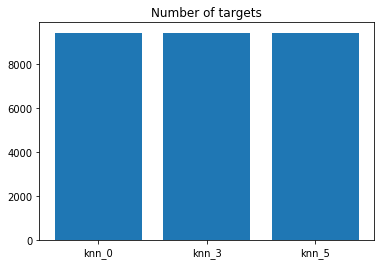

In [17]:
fig, ax = plt.subplots()
plt.title('Number of targets')
ind = np.arange(1, 4)
ax.bar(ind, num_targets)
ax.set_xticks(ind)
ax.set_xticklabels(sorted(networks.keys()))

[Text(0,0,'knn_0'), Text(0,0,'knn_3'), Text(0,0,'knn_5')]

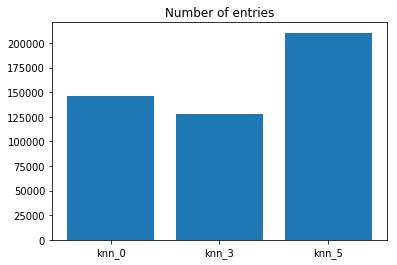

In [20]:
fig, ax = plt.subplots()
plt.title('Number of entries')
ind = np.arange(1, 4)
ax.bar(ind, [len(networks[k]) for k in networks])
ax.set_xticks(ind)
ax.set_xticklabels(sorted(networks.keys()))

0.0587105555103


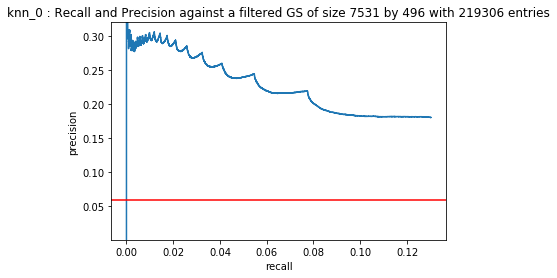

0.0587105555103


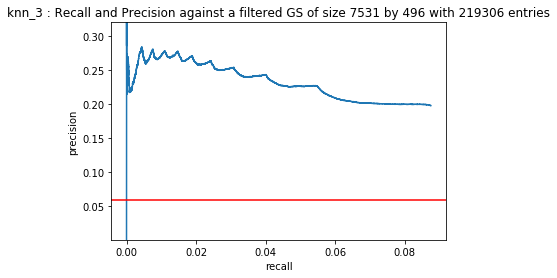

0.0587105555103


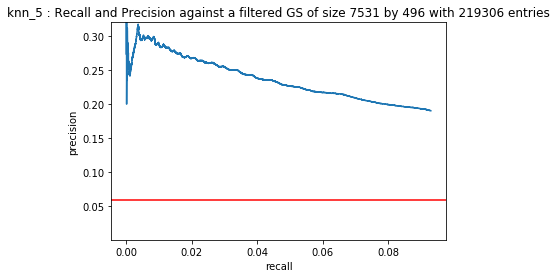

In [26]:
for k in sorted(networks.keys()):
    net = networks[k]
    filtered_gs = sup_table.loc[set(net['target']).intersection(sup_table.index), set(net['regulator']).intersection(sup_table.columns)]
    # Percentage of our network that overlaps with Marbach
    calc_and_plot_precision_and_recall(k, net, filtered_gs)

In [19]:
networks[k].head()


























,regulator,target,beta.sign.sum,beta.non.zero,var.exp.median,combined_confidences,prior
0,FBgn0029123,FBgn0033652,20.0,20.0,0.571804,0.999997,0.0
1,FBgn0002633,FBgn0004666,20.0,20.0,0.593320,0.999997,0.0
2,FBgn0004362,FBgn0003607,20.0,20.0,0.608730,0.999996,0.0
3,FBgn0001138,FBgn0262994,20.0,20.0,0.524167,0.999995,0.0
4,FBgn0004362,FBgn0010228,20.0,20.0,0.637614,0.999994,0.0


In [31]:
percentage_similarity_matrix = similarity_matrix / num_edges

Text(0.5,1,'percentage similar')

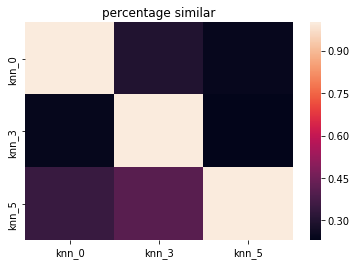

In [32]:
sns.heatmap(percentage_similarity_matrix)
plt.title('percentage similar')